# Import and preparation

In [1]:
%matplotlib inline

In [425]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from collections import namedtuple
from functools import lru_cache

from IPython.display import display
pd.options.display.max_columns = None

In [3]:
ALPHA_VANTAGE_ACCESS_KEY = context.params['alpha_vantage']['access_key']

In [4]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData

ts = TimeSeries(ALPHA_VANTAGE_ACCESS_KEY)
fd = FundamentalData(ALPHA_VANTAGE_ACCESS_KEY)

In [5]:
@lru_cache()
def historic_eps(symbol):
    response = requests.get(
        f'https://www.alphavantage.co/query?function=EARNINGS&symbol={symbol}&apikey={ALPHA_VANTAGE_ACCESS_KEY}'
    )
    data = response.json()
    if data == {}:
        raise ValueError('Error getting data from the api, no return was given.')
    elif response.status_code == 200:
        return response.json()

In [805]:
def plot_multi(s1, s2): 
    """Creates plots """
    fig, ax = plt.subplots()
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    s1.plot(ax=ax, style='b-')
    # same ax as above since it's automatically added on the right
    s2.plot(ax=ax, style='r-', secondary_y=True)
    #nvda_combined['PE'].plot(ax=ax3, style='g-')
    # nvda_combined['split_coefficient'].plot(ax=ax, style='k-')

    # add legend --> take advantage of pandas providing us access
    # to the line associated with the right part of the axis
    ax3.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],\
               [s1.name, s2.name], bbox_to_anchor=(1.5, 0.5))

# Testing

## Testing: Earnings

In [6]:
raw_aapl_earnings = historic_eps('AAPL')

In [7]:
aapl_earning = pd.DataFrame.from_records(raw_aapl_earnings['quarterlyEarnings'])
aapl_earning

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2020-12-31,2021-01-27,1.68,1.4158,0.2642,18.6608
1,2020-09-30,2020-10-29,0.73,0.6987,0.0313,4.4797
2,2020-06-30,2020-07-30,0.65,0.51,0.14,27.451
3,2020-03-31,2020-04-30,0.64,0.56,0.08,14.2857
4,2019-12-31,2020-01-28,1.25,1.14,0.11,9.6491
...,...,...,...,...,...,...
95,1997-03-31,1997-04-16,-0.05,-0.04,-0.01,-25
96,1996-12-31,1997-01-15,-0.03,-0.02,-0.01,-50
97,1996-09-30,1996-10-16,0.0018,-0.01,0.0118,118
98,1996-06-30,1996-07-17,-0.02,-0.04,0.02,50


## Testing: Daily Prices

In [8]:
raw_appl_daily, _ = ts.get_daily_adjusted('AAPL', outputsize='full')

In [9]:
aapl_daily = pd.DataFrame.from_dict(raw_appl_daily, orient='index', dtype='float')
aapl_daily.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
1999-11-05,84.62,88.37,84.00,88.31,0.679082,3721500.0,0.0,1.0
1999-11-04,82.06,85.37,80.62,83.62,0.643017,3384700.0,0.0,1.0
1999-11-03,81.62,83.25,81.00,81.50,0.626715,2932700.0,0.0,1.0
1999-11-02,78.00,81.69,77.31,80.25,0.617103,3564600.0,0.0,1.0
1999-11-01,80.00,80.69,77.37,77.62,0.596879,2487300.0,0.0,1.0


In [10]:
aapl_daily[('2021-02-01' < aapl_daily.index) & (aapl_daily.index < '2021-02-10')]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-02-09,136.62,137.877,135.85,136.01,136.010000,75986989.0,0.000,1.0
2021-02-08,136.03,136.960,134.92,136.91,136.910000,71297214.0,0.000,1.0
2021-02-05,137.35,137.420,135.86,136.76,136.760000,75693830.0,0.205,1.0
2021-02-04,136.30,137.400,134.59,137.39,137.184364,84183061.0,0.000,1.0
2021-02-03,135.76,135.770,133.61,133.94,133.739528,89880937.0,0.000,1.0
2021-02-02,135.73,136.310,134.61,134.99,134.787956,82266419.0,0.000,1.0


# Download multiple stocks earnings and prices

In [11]:
stocks = ['PEP', 'PG', 'KO', 'AAPL', 'AMZN', 'DIS', 'QCOM', 'NVDA']

In [12]:
historic = {}
Alpha = namedtuple('Alpha', ['prices', 'earnings'])

for stock in stocks:
    
    prices, _ = ts.get_daily_adjusted(stock, outputsize='full')
    sleep(12)
    earnings = historic_eps(stock)
    
    historic[stock] = Alpha(
        prices = pd.DataFrame.from_dict(prices, orient='index', dtype='float'),
        earnings = pd.DataFrame.from_records(earnings['quarterlyEarnings']),
    )
    
    sleep(12)
      

# Data Exploration 

## Earnings

In [13]:
nvda_earnings = historic['NVDA'].earnings.copy()
nvda_earnings

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2021-01-31,2021-02-24,3.1,2.8089,0.2911,10.3635
1,2020-10-31,2020-11-18,2.91,2.5482,0.3618,14.1983
2,2020-07-31,2020-08-19,2.18,1.9699,0.2101,10.6655
3,2020-04-30,2020-05-21,1.8,1.6843,0.1157,6.8693
4,2020-01-31,2020-02-13,1.89,1.6745,0.2155,12.8695
...,...,...,...,...,...,...
83,2000-04-30,2000-05-16,0.04,0.03,0.01,33.3333
84,2000-01-31,2000-02-15,0.03,0.03,0,0
85,1999-10-31,1999-11-18,0.02,0.02,0,0
86,1999-07-31,1999-08-18,0.02,0.02,0,0


In [14]:
nvda_earnings.index = pd.DatetimeIndex(nvda_earnings['reportedDate'])
nvda_earnings.sort_index(inplace=True)
nvda_earnings['EPS_ttm'] = nvda_earnings['reportedEPS'].rolling(4).sum().round(2)

In [15]:
nvda_earnings

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,EPS_ttm
reportedDate,,,,,,,
1999-05-18,1999-04-30,1999-05-18,0.02,0.01,0.01,100,NaN
1999-08-18,1999-07-31,1999-08-18,0.02,0.02,0,0,NaN
1999-11-18,1999-10-31,1999-11-18,0.02,0.02,0,0,NaN
2000-02-15,2000-01-31,2000-02-15,0.03,0.03,0,0,0.09
2000-05-16,2000-04-30,2000-05-16,0.04,0.03,0.01,33.3333,0.11
...,...,...,...,...,...,...,...
2020-02-13,2020-01-31,2020-02-13,1.89,1.6745,0.2155,12.8695,5.79
2020-05-21,2020-04-30,2020-05-21,1.8,1.6843,0.1157,6.8693,6.71
2020-08-19,2020-07-31,2020-08-19,2.18,1.9699,0.2101,10.6655,7.65


## Prices

In [16]:
nvda_prices = historic['NVDA'].prices.copy()

nvda_prices.rename(
    {
        '1. open': 'open',
        '2. high': 'high',
        '3. low' : 'low',
        '4. close': 'close',
        '5. adjusted close': 'adjusted_close',
        '6. volume': 'volume',
        '7. dividend amount': 'dividend',
        '8. split coefficient': 'split_coefficient'
    },
    inplace=True,
    axis='columns'
)


nvda_prices.index = pd.DatetimeIndex(nvda_prices.index)
nvda_prices.head()

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
2021-04-01,542.890,554.80,540.45,552.47,552.47,7706865.0,0.0,1.0
2021-03-31,520.620,538.82,519.30,533.93,533.93,7869438.0,0.0,1.0
2021-03-30,513.678,519.01,508.20,514.87,514.87,5005062.0,0.0,1.0
2021-03-29,512.810,522.50,508.00,517.93,517.93,6837997.0,0.0,1.0
2021-03-26,502.180,514.25,494.94,513.57,513.57,9099224.0,0.0,1.0


## Combine Earnings & Prices

In [17]:
nvda_combined = pd.merge_asof(nvda_prices.sort_index(), nvda_earnings.sort_index(), left_index=True, right_index=True)

In [18]:
nvda_combined['reportedEPS'] = nvda_combined['reportedEPS'].astype(float)

### PE ratio 

<AxesSubplot:>

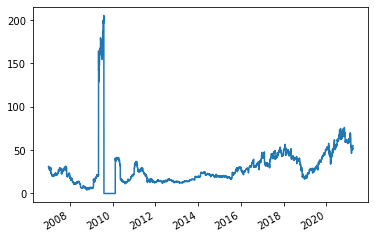

In [19]:
nvda_combined.eval('PE = adjusted_close / EPS_ttm', inplace=True)
nvda_combined['PE'] = [pe if 0 < pe < np.inf else 0 for pe in nvda_combined['PE']]
# nvda_combined[nvda_combined.year == 2007].head(20)
nvda_combined[nvda_combined.index.year > 2006].PE.plot()

In [20]:
nvda_combined[nvda_combined['split_coefficient'] != 1.0]

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,EPS_ttm,PE
2000-06-27,82.25,83.63,69.06,71.25,10.915651,1259600.0,0.0,2.000000,2000-04-30,2000-05-16,0.04,0.03,0.01,33.3333,0.11,99.233194
2001-09-17,35.52,36.39,33.82,33.99,10.414680,4744150.0,0.0,2.000000,2001-07-31,2001-08-14,0.07,0.07,0,0,0.21,49.593716
2006-04-07,30.44,30.75,29.93,30.53,18.709043,5688933.0,0.0,2.000000,2006-01-31,2006-02-16,0.18,0.16,0.02,12.5,0.69,27.114556
2007-09-11,34.35,34.84,33.91,34.58,31.786361,6757067.0,0.0,1.499999,2007-07-31,2007-08-09,0.34,0.28,0.06,21.4286,1.16,27.402035


In [21]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

In [22]:
nvda_combined['year'] = nvda_combined.index.year

In [23]:
nvda_combined2009 = nvda_combined[nvda_combined['year'] == 2009]

IndexError: list index out of range

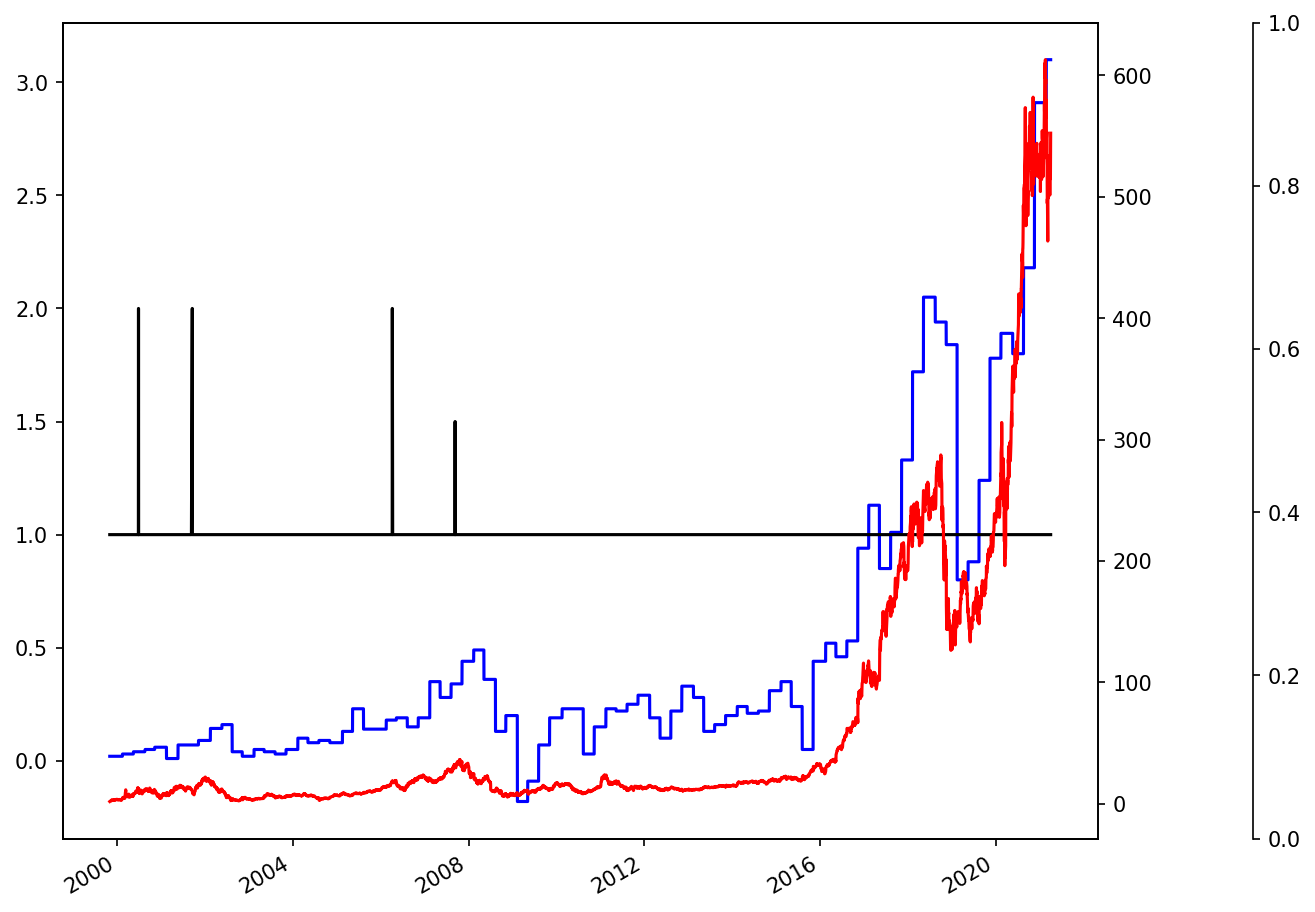

In [24]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

nvda_combined['reportedEPS'].plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
nvda_combined['adjusted_close'].plot(ax=ax, style='r-', secondary_y=True)
#nvda_combined['PE'].plot(ax=ax3, style='g-')
nvda_combined['split_coefficient'].plot(ax=ax, style='k-')

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax3.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax3.get_lines()[0]],\
           ['A','B','C'], bbox_to_anchor=(1.5, 0.5))

<AxesSubplot:xlabel='reportedDate'>

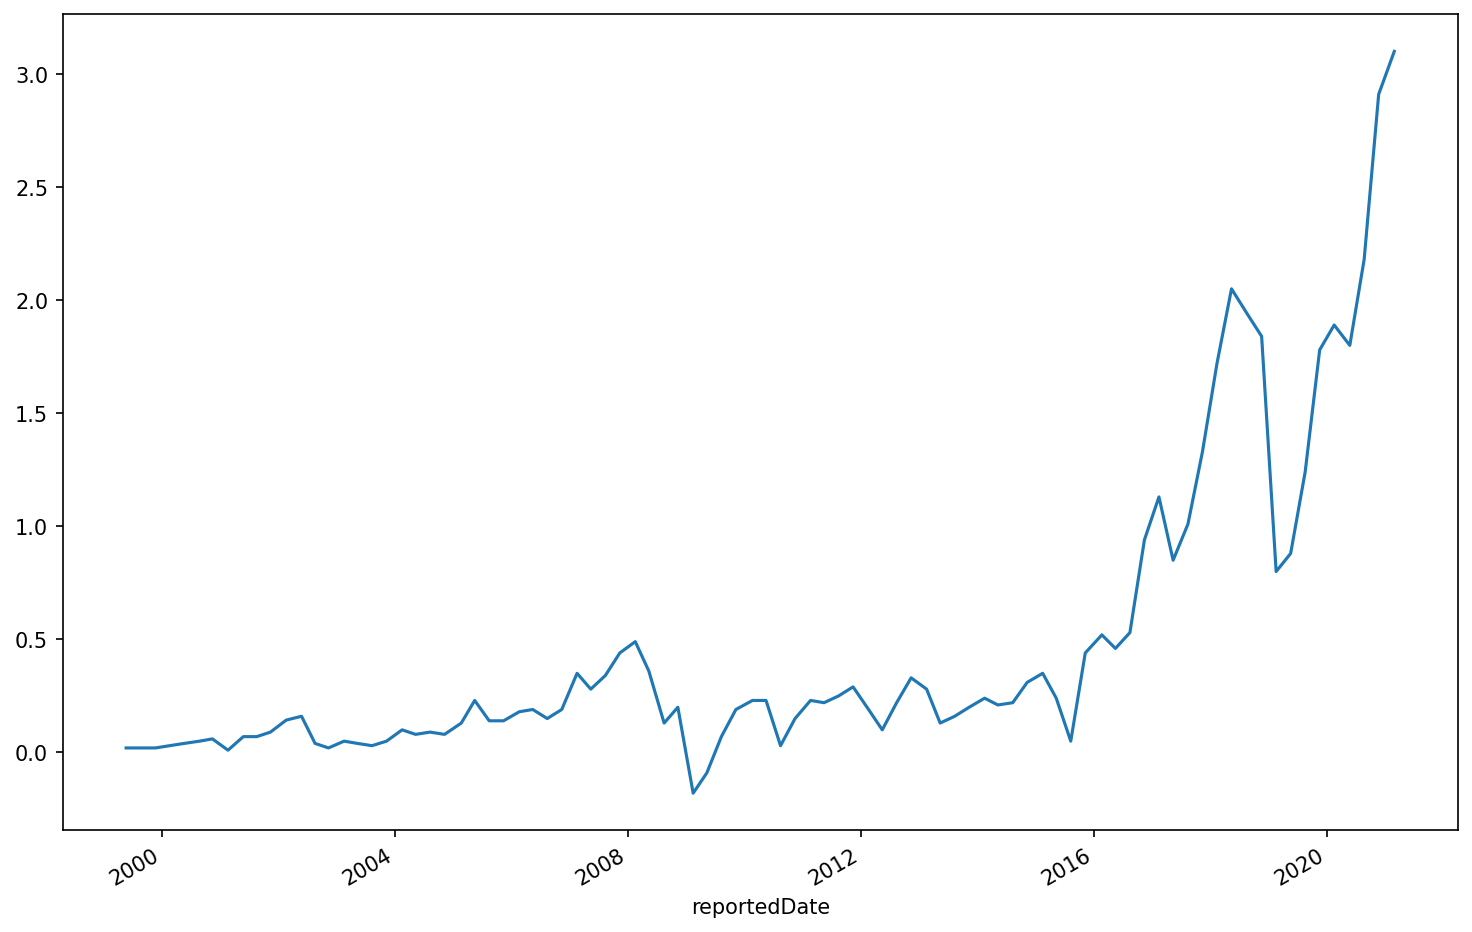

In [25]:
nvda_earnings.reportedEPS.astype(float).plot()

### Adjusted High, Low, Open

In [26]:
nvda_combined = (
    nvda_combined
    .eval('factor = 1 + (close - adjusted_close) / adjusted_close')
    .eval('adjusted_open = open / factor')
    .eval('adjusted_high = high / factor')
    .eval('adjusted_low  = low / factor')
)
nvda_combined

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,...,estimatedEPS,surprise,surprisePercentage,EPS_ttm,PE,year,factor,adjusted_open,adjusted_high,adjusted_low
1999-11-01,21.750,24.38,21.75,23.50,1.800125,1630300.0,0.0,1.0,1999-07-31,1999-08-18,...,0.02,0,0,NaN,0.000000,1999,13.054649,1.666073,1.867534,1.666073
1999-11-02,23.940,25.13,23.75,25.00,1.915027,1744800.0,0.0,1.0,1999-07-31,1999-08-18,...,0.02,0,0,NaN,0.000000,1999,13.054649,1.833829,1.924985,1.819275
1999-11-03,26.000,28.13,25.81,27.44,2.101933,4191000.0,0.0,1.0,1999-07-31,1999-08-18,...,0.02,0,0,NaN,0.000000,1999,13.054649,1.991628,2.154788,1.977073
1999-11-04,27.750,29.94,27.75,29.19,2.235985,2625700.0,0.0,1.0,1999-07-31,1999-08-18,...,0.02,0,0,NaN,0.000000,1999,13.054649,2.125679,2.293436,2.125679
1999-11-05,30.000,30.25,26.88,28.25,2.163980,1284100.0,0.0,1.0,1999-07-31,1999-08-18,...,0.02,0,0,NaN,0.000000,1999,13.054649,2.298032,2.317182,2.059037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,502.180,514.25,494.94,513.57,513.570000,9099224.0,0.0,1.0,2021-01-31,2021-02-24,...,2.8089,0.2911,10.3635,9.99,51.408408,2021,1.000000,502.180000,514.250000,494.940000
2021-03-29,512.810,522.50,508.00,517.93,517.930000,6837997.0,0.0,1.0,2021-01-31,2021-02-24,...,2.8089,0.2911,10.3635,9.99,51.844845,2021,1.000000,512.810000,522.500000,508.000000
2021-03-30,513.678,519.01,508.20,514.87,514.870000,5005062.0,0.0,1.0,2021-01-31,2021-02-24,...,2.8089,0.2911,10.3635,9.99,51.538539,2021,1.000000,513.678000,519.010000,508.200000
2021-03-31,520.620,538.82,519.30,533.93,533.930000,7869438.0,0.0,1.0,2021-01-31,2021-02-24,...,2.8089,0.2911,10.3635,9.99,53.446446,2021,1.000000,520.620000,538.820000,519.300000


<AxesSubplot:>

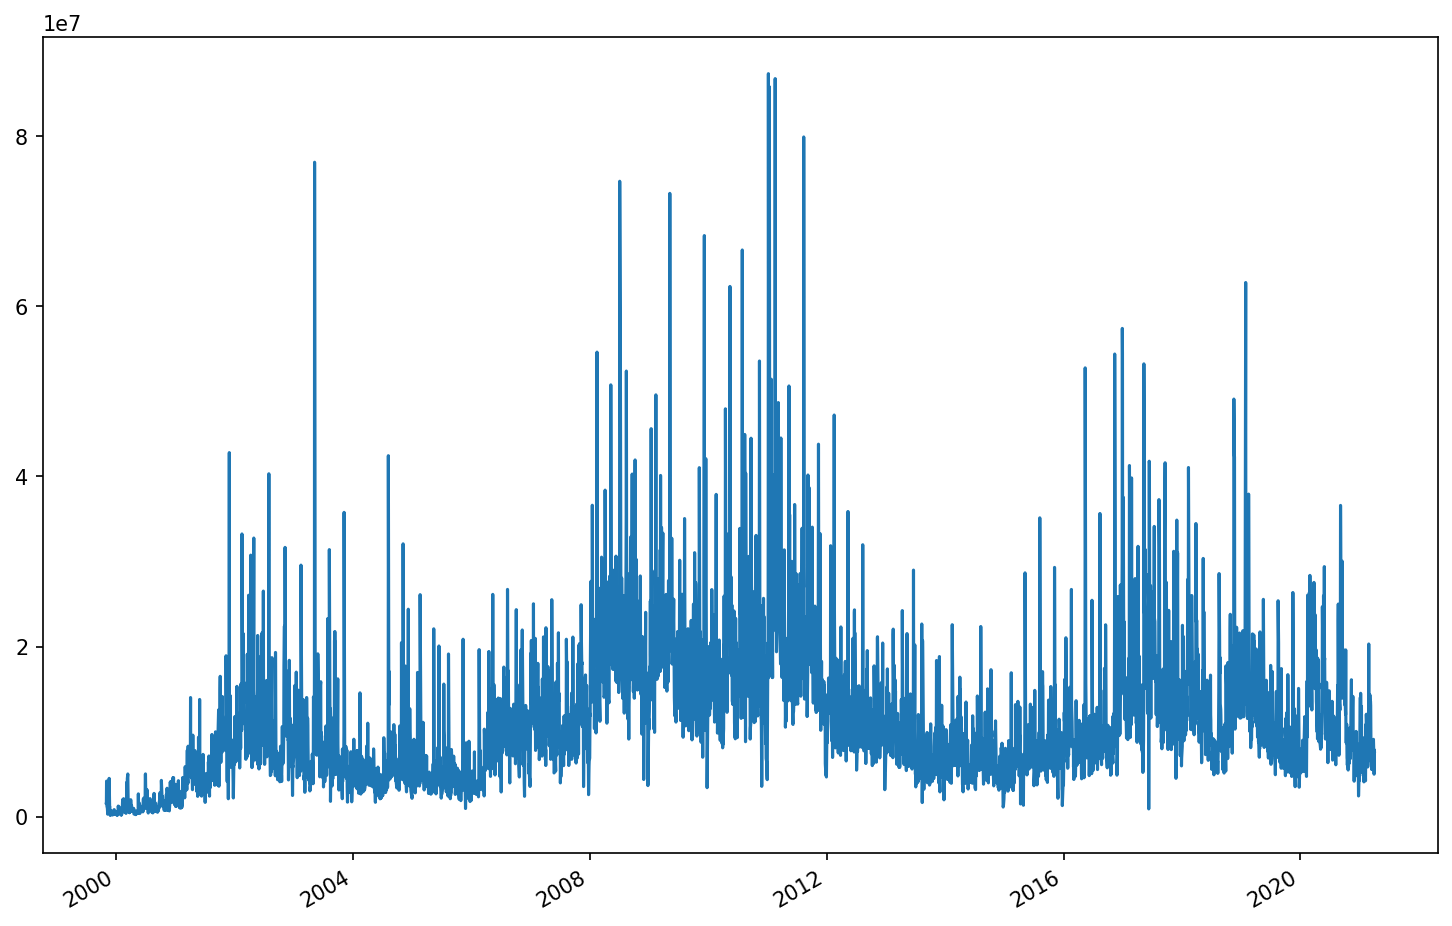

In [27]:
nvda_combined.volume.plot()

### Adjusted Volume

In [28]:
nvda_combined['split_factor'] = nvda_combined.sort_index(ascending=False).split_coefficient.cumprod()

In [29]:
nvda_combined.eval('adjusted_volume = volume * split_factor / split_coefficient', inplace=True) 
nvda_combined

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,...,surprisePercentage,EPS_ttm,PE,year,factor,adjusted_open,adjusted_high,adjusted_low,split_factor,adjusted_volume
1999-11-01,21.750,24.38,21.75,23.50,1.800125,1630300.0,0.0,1.0,1999-07-31,1999-08-18,...,0,NaN,0.000000,1999,13.054649,1.666073,1.867534,1.666073,11.999994,1.956359e+07
1999-11-02,23.940,25.13,23.75,25.00,1.915027,1744800.0,0.0,1.0,1999-07-31,1999-08-18,...,0,NaN,0.000000,1999,13.054649,1.833829,1.924985,1.819275,11.999994,2.093759e+07
1999-11-03,26.000,28.13,25.81,27.44,2.101933,4191000.0,0.0,1.0,1999-07-31,1999-08-18,...,0,NaN,0.000000,1999,13.054649,1.991628,2.154788,1.977073,11.999994,5.029197e+07
1999-11-04,27.750,29.94,27.75,29.19,2.235985,2625700.0,0.0,1.0,1999-07-31,1999-08-18,...,0,NaN,0.000000,1999,13.054649,2.125679,2.293436,2.125679,11.999994,3.150838e+07
1999-11-05,30.000,30.25,26.88,28.25,2.163980,1284100.0,0.0,1.0,1999-07-31,1999-08-18,...,0,NaN,0.000000,1999,13.054649,2.298032,2.317182,2.059037,11.999994,1.540919e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,502.180,514.25,494.94,513.57,513.570000,9099224.0,0.0,1.0,2021-01-31,2021-02-24,...,10.3635,9.99,51.408408,2021,1.000000,502.180000,514.250000,494.940000,1.000000,9.099224e+06
2021-03-29,512.810,522.50,508.00,517.93,517.930000,6837997.0,0.0,1.0,2021-01-31,2021-02-24,...,10.3635,9.99,51.844845,2021,1.000000,512.810000,522.500000,508.000000,1.000000,6.837997e+06
2021-03-30,513.678,519.01,508.20,514.87,514.870000,5005062.0,0.0,1.0,2021-01-31,2021-02-24,...,10.3635,9.99,51.538539,2021,1.000000,513.678000,519.010000,508.200000,1.000000,5.005062e+06
2021-03-31,520.620,538.82,519.30,533.93,533.930000,7869438.0,0.0,1.0,2021-01-31,2021-02-24,...,10.3635,9.99,53.446446,2021,1.000000,520.620000,538.820000,519.300000,1.000000,7.869438e+06


In [30]:
nvda_combined[(nvda_combined.index > '2020-08-01') & (nvda_combined.index < '2020-09-20')]

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,...,surprisePercentage,EPS_ttm,PE,year,factor,adjusted_open,adjusted_high,adjusted_low,split_factor,adjusted_volume
2020-08-03,429.3000,443.9500,428.6100,440.41,440.010572,10325456.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,65.575346,2020,1.000908,428.910649,443.547362,428.221274,1.0,10325456.0
2020-08-04,442.0000,449.1100,436.2401,449.11,448.702682,7758390.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,66.870742,2020,1.000908,441.599130,448.702682,435.844454,1.0,7758390.0
2020-08-05,449.7600,454.8672,446.6500,451.47,451.060542,6262493.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,67.222137,2020,1.000908,449.352093,454.454661,446.244913,1.0,6262493.0
2020-08-06,453.9900,454.3200,447.1500,453.42,453.008773,6107892.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,67.512485,2020,1.000908,453.578256,453.907957,446.744460,1.0,6107892.0
2020-08-07,452.5000,460.1900,441.5000,447.98,447.573707,8562899.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,66.702490,2020,1.000908,452.089608,459.772633,441.099584,1.0,8562899.0
2020-08-10,453.3700,456.3300,434.2600,446.60,446.194958,10694898.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,66.497013,2020,1.000908,452.958818,455.916134,433.866150,1.0,10694898.0
2020-08-11,442.9500,445.4700,431.8300,434.00,433.606386,8862763.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,64.620922,2020,1.000908,442.548269,445.065983,431.438354,1.0,8862763.0
2020-08-12,439.6300,458.6800,438.3300,457.61,457.194973,11623573.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,68.136360,2020,1.000908,439.231280,458.264003,437.932459,1.0,11623573.0
2020-08-13,461.8400,468.8700,454.2300,457.72,457.304873,9361489.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,68.152738,2020,1.000908,461.421137,468.444761,453.818039,1.0,9361489.0
2020-08-14,461.2000,468.1900,457.6200,462.56,462.140484,9160904.0,0.00,1.0,2020-04-30,2020-05-21,...,6.8693,6.71,68.873395,2020,1.000908,460.781717,467.765378,457.204964,1.0,9160904.0


<AxesSubplot:>

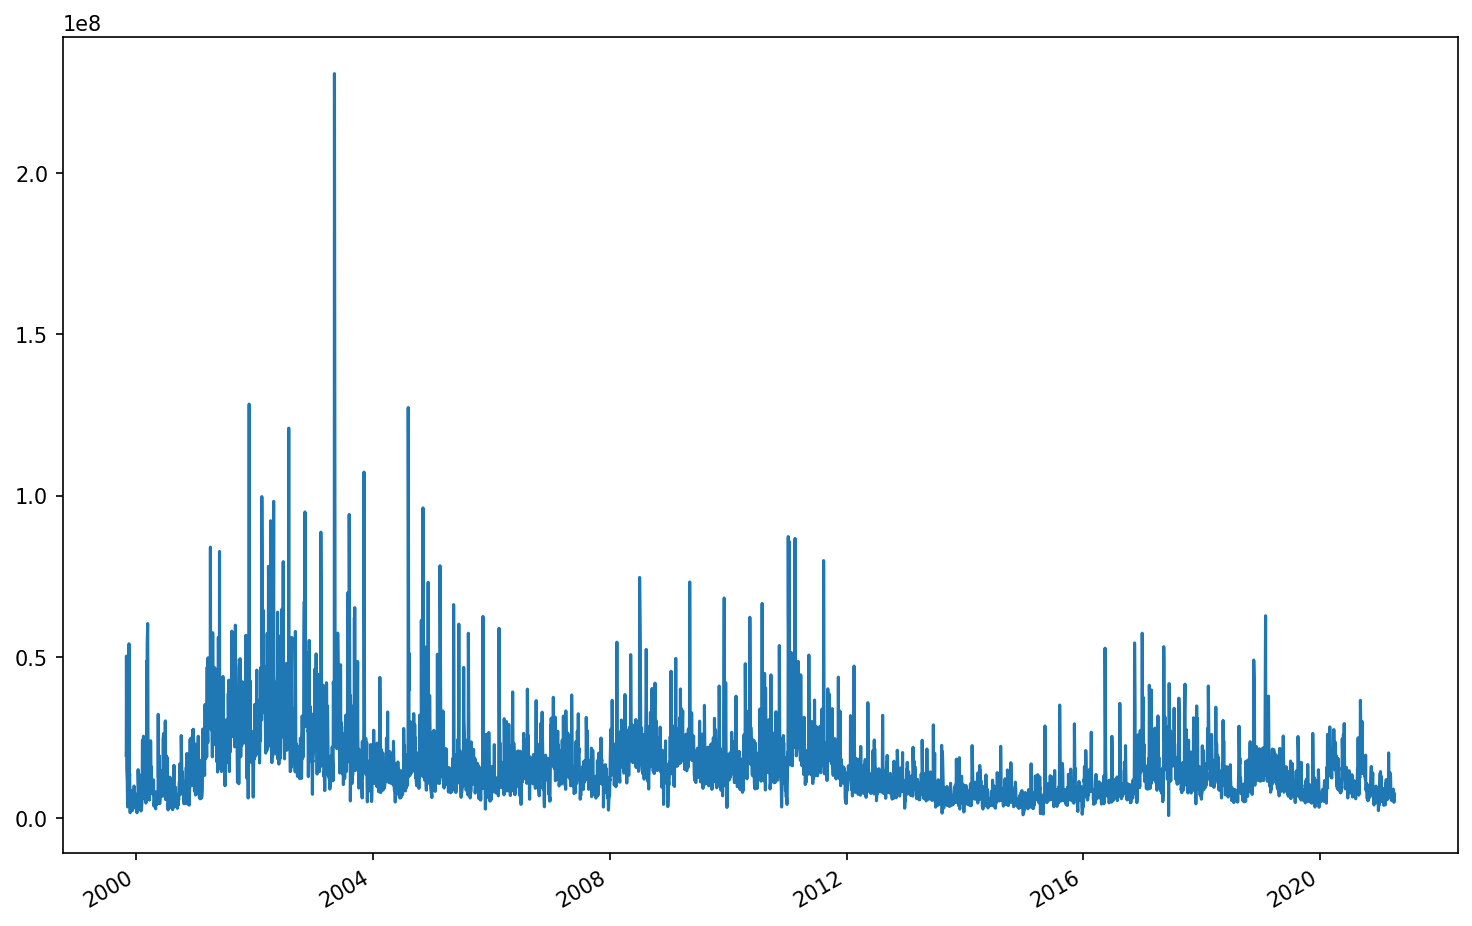

In [31]:
nvda_combined.adjusted_volume.plot()

### Dividend Yield

In [32]:
nvda_dividends = nvda_combined[nvda_combined['dividend'] > 0][['close', 'adjusted_close', 'dividend', 'year']]

In [33]:
nvda_dividends.eval('dividend_pct = dividend / close', inplace=True)

In [34]:
nvda_dividends['dividend_yield'] = nvda_dividends.rolling('365d')['dividend_pct'].sum()

In [35]:
nvda_combined['dividend_yield'] = nvda_dividends['dividend_yield']

In [36]:
nvda_combined

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,...,EPS_ttm,PE,year,factor,adjusted_open,adjusted_high,adjusted_low,split_factor,adjusted_volume,dividend_yield
1999-11-01,21.750,24.38,21.75,23.50,1.800125,1630300.0,0.0,1.0,1999-07-31,1999-08-18,...,NaN,0.000000,1999,13.054649,1.666073,1.867534,1.666073,11.999994,1.956359e+07,NaN
1999-11-02,23.940,25.13,23.75,25.00,1.915027,1744800.0,0.0,1.0,1999-07-31,1999-08-18,...,NaN,0.000000,1999,13.054649,1.833829,1.924985,1.819275,11.999994,2.093759e+07,NaN
1999-11-03,26.000,28.13,25.81,27.44,2.101933,4191000.0,0.0,1.0,1999-07-31,1999-08-18,...,NaN,0.000000,1999,13.054649,1.991628,2.154788,1.977073,11.999994,5.029197e+07,NaN
1999-11-04,27.750,29.94,27.75,29.19,2.235985,2625700.0,0.0,1.0,1999-07-31,1999-08-18,...,NaN,0.000000,1999,13.054649,2.125679,2.293436,2.125679,11.999994,3.150838e+07,NaN
1999-11-05,30.000,30.25,26.88,28.25,2.163980,1284100.0,0.0,1.0,1999-07-31,1999-08-18,...,NaN,0.000000,1999,13.054649,2.298032,2.317182,2.059037,11.999994,1.540919e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,502.180,514.25,494.94,513.57,513.570000,9099224.0,0.0,1.0,2021-01-31,2021-02-24,...,9.99,51.408408,2021,1.000000,502.180000,514.250000,494.940000,1.000000,9.099224e+06,NaN
2021-03-29,512.810,522.50,508.00,517.93,517.930000,6837997.0,0.0,1.0,2021-01-31,2021-02-24,...,9.99,51.844845,2021,1.000000,512.810000,522.500000,508.000000,1.000000,6.837997e+06,NaN
2021-03-30,513.678,519.01,508.20,514.87,514.870000,5005062.0,0.0,1.0,2021-01-31,2021-02-24,...,9.99,51.538539,2021,1.000000,513.678000,519.010000,508.200000,1.000000,5.005062e+06,NaN
2021-03-31,520.620,538.82,519.30,533.93,533.930000,7869438.0,0.0,1.0,2021-01-31,2021-02-24,...,9.99,53.446446,2021,1.000000,520.620000,538.820000,519.300000,1.000000,7.869438e+06,NaN


In [37]:
pd.merge(nvda_combined, nvda_dividends['dividend_yield'], how='left', left_index=True, right_index=True).fillna(0)

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,fiscalDateEnding,reportedDate,...,PE,year,factor,adjusted_open,adjusted_high,adjusted_low,split_factor,adjusted_volume,dividend_yield_x,dividend_yield_y
1999-11-01,21.750,24.38,21.75,23.50,1.800125,1630300.0,0.0,1.0,1999-07-31,1999-08-18,...,0.000000,1999,13.054649,1.666073,1.867534,1.666073,11.999994,1.956359e+07,0.0,0.0
1999-11-02,23.940,25.13,23.75,25.00,1.915027,1744800.0,0.0,1.0,1999-07-31,1999-08-18,...,0.000000,1999,13.054649,1.833829,1.924985,1.819275,11.999994,2.093759e+07,0.0,0.0
1999-11-03,26.000,28.13,25.81,27.44,2.101933,4191000.0,0.0,1.0,1999-07-31,1999-08-18,...,0.000000,1999,13.054649,1.991628,2.154788,1.977073,11.999994,5.029197e+07,0.0,0.0
1999-11-04,27.750,29.94,27.75,29.19,2.235985,2625700.0,0.0,1.0,1999-07-31,1999-08-18,...,0.000000,1999,13.054649,2.125679,2.293436,2.125679,11.999994,3.150838e+07,0.0,0.0
1999-11-05,30.000,30.25,26.88,28.25,2.163980,1284100.0,0.0,1.0,1999-07-31,1999-08-18,...,0.000000,1999,13.054649,2.298032,2.317182,2.059037,11.999994,1.540919e+07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,502.180,514.25,494.94,513.57,513.570000,9099224.0,0.0,1.0,2021-01-31,2021-02-24,...,51.408408,2021,1.000000,502.180000,514.250000,494.940000,1.000000,9.099224e+06,0.0,0.0
2021-03-29,512.810,522.50,508.00,517.93,517.930000,6837997.0,0.0,1.0,2021-01-31,2021-02-24,...,51.844845,2021,1.000000,512.810000,522.500000,508.000000,1.000000,6.837997e+06,0.0,0.0
2021-03-30,513.678,519.01,508.20,514.87,514.870000,5005062.0,0.0,1.0,2021-01-31,2021-02-24,...,51.538539,2021,1.000000,513.678000,519.010000,508.200000,1.000000,5.005062e+06,0.0,0.0
2021-03-31,520.620,538.82,519.30,533.93,533.930000,7869438.0,0.0,1.0,2021-01-31,2021-02-24,...,53.446446,2021,1.000000,520.620000,538.820000,519.300000,1.000000,7.869438e+06,0.0,0.0


<AxesSubplot:>

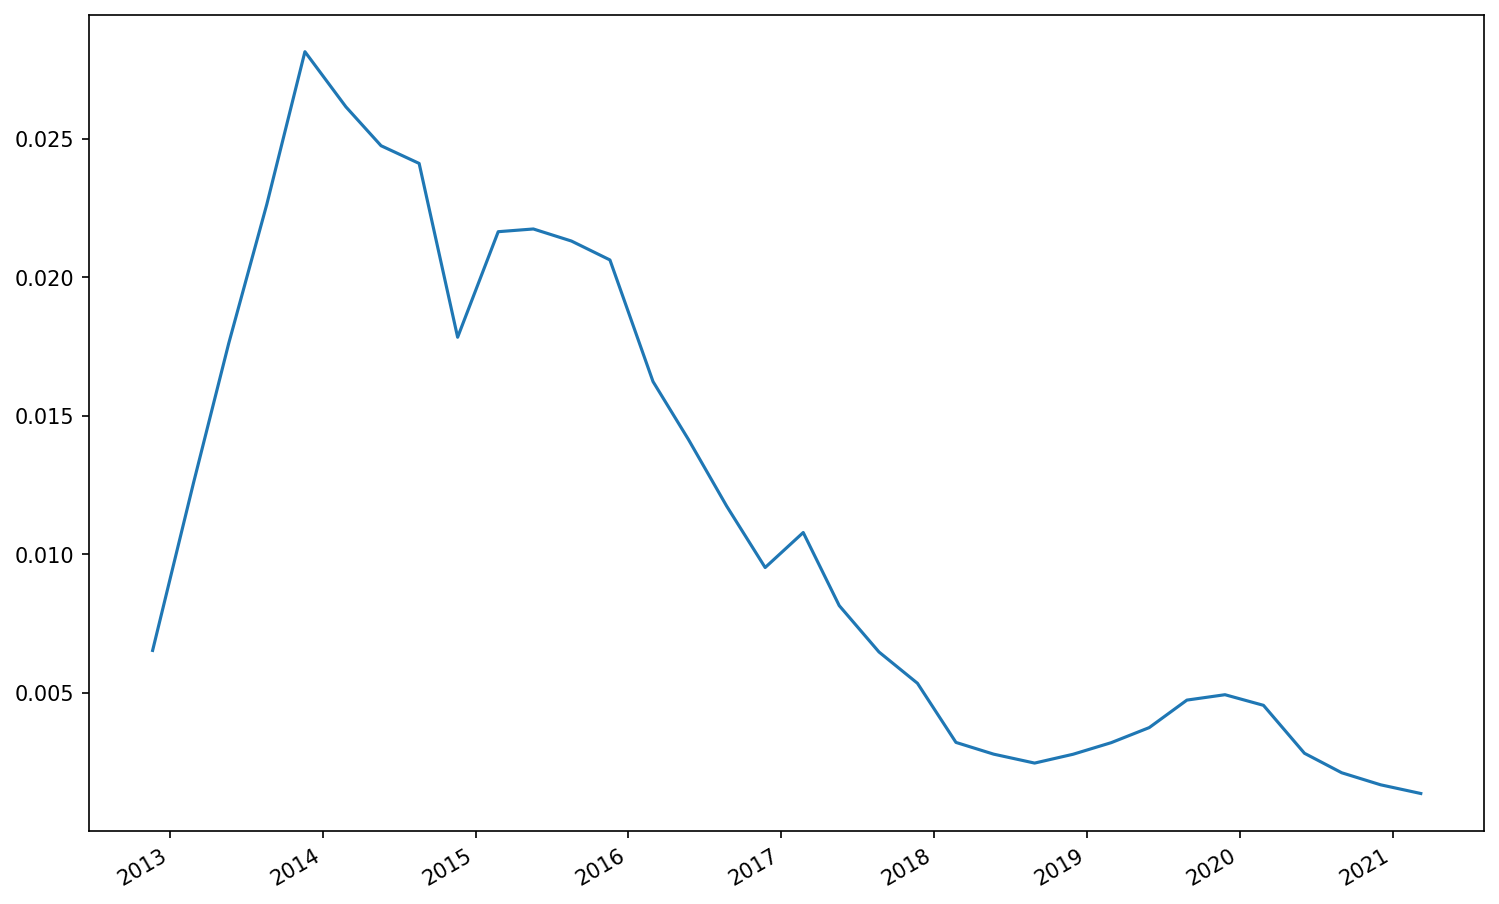

In [38]:
nvda_dividends['dividend_yield'].plot()

# Loop all stocks

In [39]:
def prepare_raw_earnings_data(df: pd.DataFrame) -> pd.DataFrame:
       
    # surprise percentage & reported date
    df = df.rename(columns={
        'surprisePercentage': 'EPS_surprise_pct', 
        'reportedDate': 'reported_date'
    }, errors='raise')
    
    df['EPS_surprise_pct'] = df['EPS_surprise_pct'].replace('None', '0').astype(float) / 100
    df['reported_date'] = pd.to_datetime(df['reported_date'])
    
    # convert index to reported date, in preparation for later join
    df.index = df['reported_date']
    
    # create trailing 12 month EPS
    df.sort_index(inplace=True)
    df['EPS_ttm'] = df['reportedEPS'].rolling(4).sum().round(2).fillna(method='bfill')
    
    return df[['EPS_ttm', 'EPS_surprise_pct', 'reported_date']]

In [40]:
def prepare_raw_prices_data(df: pd.DataFrame) -> pd.DataFrame:
    
    df.index = pd.DatetimeIndex(df.index)
    
    df = (df
        # rename Alpha Vantage column names
        .rename(columns={
            '1. open': 'open',
            '2. high': 'high',
            '3. low' : 'low',
            '4. close': 'close',
            '5. adjusted close': 'adjusted_close',
            '6. volume': 'volume',
            '7. dividend amount': 'dividend',
            '8. split coefficient': 'split_coefficient'
            }
        )
        
        # create adjusted versions of columns
        .eval('factor = 1 + (close - adjusted_close) / adjusted_close')
        .eval('adjusted_open = open / factor')
        .eval('adjusted_high = high / factor')
        .eval('adjusted_low  = low / factor')
    )

    # create adjusted volume
    df['split_factor'] = df.sort_index(ascending=False).split_coefficient.cumprod()
    df.eval('adjusted_volume = volume * split_factor / split_coefficient', inplace=True) 
        
    # create dividend 12 month yield
    df.sort_index(ascending=True, inplace=True)
    df.eval('dividend_pct = dividend / close', inplace=True)
    df['dividend_yield'] = df.rolling('365d')['dividend_pct'].sum()
    if df['dividend_yield'].max() > 0:
        df['dividend_yield'] = df['dividend_yield'].replace(0, np.NaN).fillna(method='ffill').fillna(0)
        
       
    return df

In [41]:
def combine_earnings_and_prices(earnings: pd.DataFrame, prices: pd.DataFrame) -> pd.DataFrame:
    
    # combine prices and earnings, using closest date to join
    combined = pd.merge_asof(
        prices.sort_index(), earnings.sort_index(), left_index=True, right_index=True
    )
    
    # create PE ratio based adjusted close and 12 month EPS
    combined['PE'] = [
        pe if 0 < pe < np.inf else 0 
        for pe in (combined.adjusted_close / combined.EPS_ttm)
    ]
    
    # remove unneeded columns
    combined.drop(columns=['factor', 'split_factor'], inplace=True)
    
    return combined

In [42]:
stocks_data = {}

for stock in stocks:
    
    stock_earnings = prepare_raw_earnings_data(historic[stock].earnings)
    stock_prices = prepare_raw_prices_data(historic[stock].prices)
    stocks_data[stock] = combine_earnings_and_prices(stock_earnings, stock_prices)
    

In [43]:
stocks_data.keys()

dict_keys(['PEP', 'PG', 'KO', 'AAPL', 'AMZN', 'DIS', 'QCOM', 'NVDA'])

In [45]:
stocks_data['PEP'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5389 entries, 1999-11-01 to 2021-04-01
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   open               5389 non-null   float64       
 1   high               5389 non-null   float64       
 2   low                5389 non-null   float64       
 3   close              5389 non-null   float64       
 4   adjusted_close     5389 non-null   float64       
 5   volume             5389 non-null   float64       
 6   dividend           5389 non-null   float64       
 7   split_coefficient  5389 non-null   float64       
 8   adjusted_open      5389 non-null   float64       
 9   adjusted_high      5389 non-null   float64       
 10  adjusted_low       5389 non-null   float64       
 11  adjusted_volume    5389 non-null   float64       
 12  dividend_pct       5389 non-null   float64       
 13  dividend_yield     5389 non-null   float64   

# Predictive model

In [607]:
# predict amount stock will increase (or decrease)
# probability stock will hit stop loss over the next week

# use kelly to caclulate bank-roll proportion
# figure out appropiate way to measure performance

## Features

### Share price increase

In [294]:
df = stocks_data['PEP']
df.head()

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,adjusted_open,adjusted_high,adjusted_low,adjusted_volume,dividend_pct,dividend_yield,EPS_ttm,EPS_surprise_pct,reported_date,PE
1999-11-01,34.44,34.56,33.56,33.56,19.933384,3635000.0,0.0,1.0,20.456071,20.527347,19.933384,3635000.0,0.0,0.0,1.14,0.030303,1999-10-06,17.485425
1999-11-02,33.63,34.31,33.56,33.69,20.010599,2682900.0,0.0,1.0,19.974962,20.378856,19.933384,2682900.0,0.0,0.0,1.14,0.030303,1999-10-06,17.553157
1999-11-03,33.81,34.31,33.75,34.25,20.343219,2898500.0,0.0,1.0,20.081875,20.378856,20.046237,2898500.0,0.0,0.0,1.14,0.030303,1999-10-06,17.844929
1999-11-04,34.25,34.56,32.06,33.00,19.600765,4683900.0,0.0,1.0,20.343219,20.527347,19.042440,4683900.0,0.0,0.0,1.14,0.030303,1999-10-06,17.193654
1999-11-05,33.00,34.06,33.00,33.81,20.081875,4080100.0,0.0,1.0,19.600765,20.230366,19.600765,4080100.0,0.0,0.0,1.14,0.030303,1999-10-06,17.615680


<AxesSubplot:>

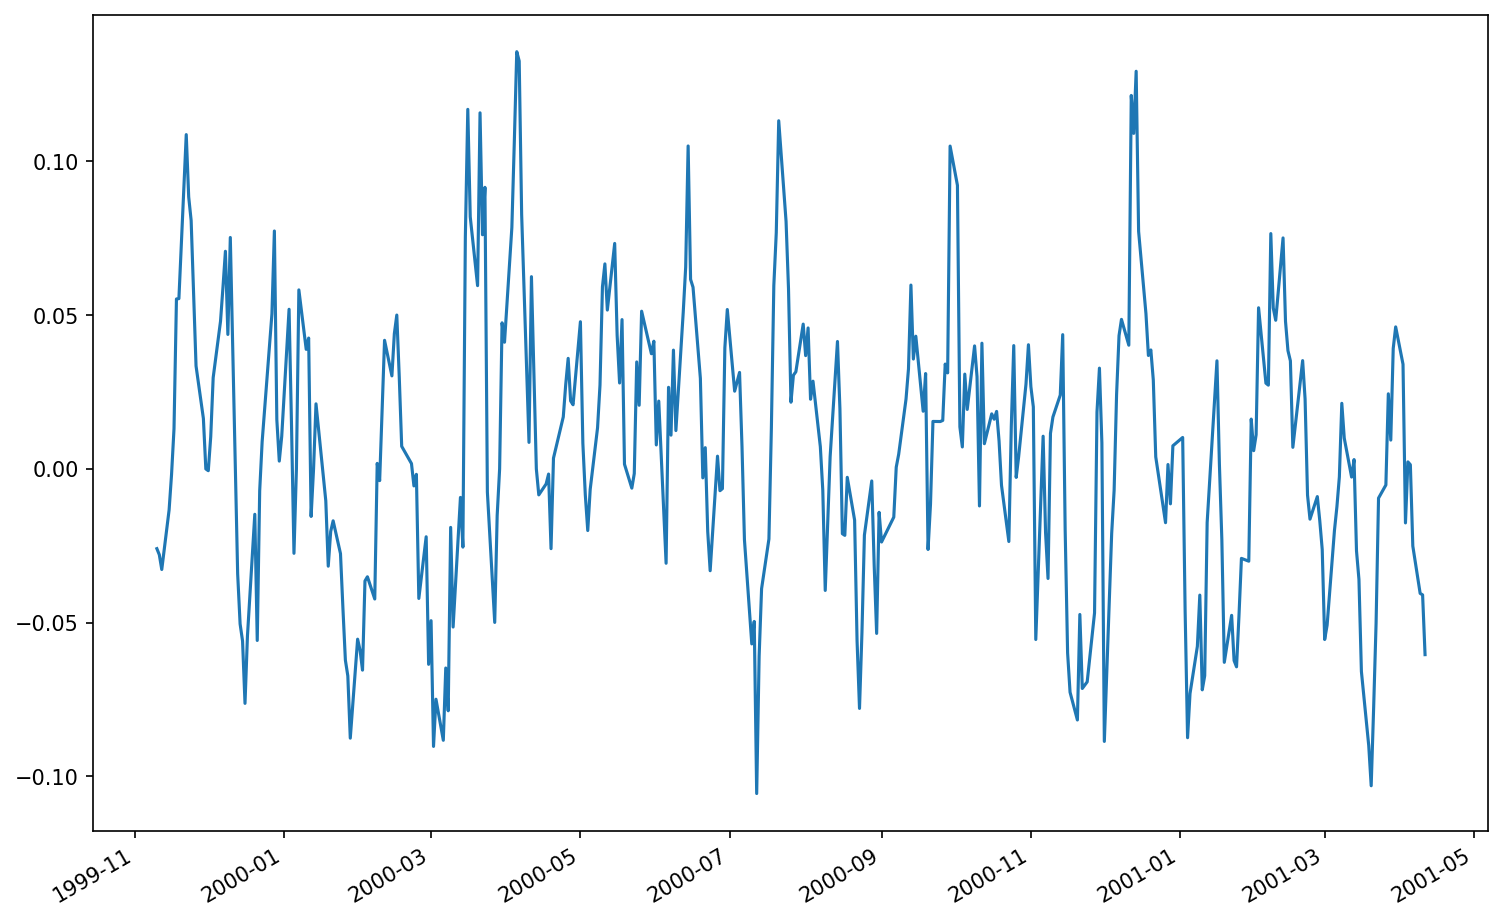

In [1088]:
df['daily'] = df.adjusted_close / df.adjusted_close.shift(1) - 1
df['weekly'] = df.adjusted_close / df.adjusted_close.shift(7) - 1
df['monthly'] = df.adjusted_close / df.adjusted_close.shift(30) - 1
df.weekly[:365].plot()

### Create typical indicators

In [1080]:
import importlib
import Finance #import the module here, so that it can be reloaded.
importlib.reload(Finance)

<module 'Finance' from 'C:\\Users\\rick-\\OneDrive\\Projects\\Investing\\Sandbox\\Investing\\notebooks\\Finance.py'>

In [1081]:
df['RSI'] = Finance.RSI(df.adjusted_close, n=14)
df['CCI'] = Finance.CCI(df.adjusted_high, df.adjusted_low, df.adjusted_close, win=50)
df['STOK'] = Finance.STOK(df.adjusted_high, df.adjusted_low, df.adjusted_close, n=14)
df['OBV'] = Finance.OBV(df.adjusted_close, df.adjusted_volume)
df['OBVMA'] = Finance.OBVMA(df.adjusted_close, df.adjusted_volume, n=20)
df['WilliamsPctRange'] = Finance.WilliamsPctRange(df.adjusted_high, df.adjusted_low, df.adjusted_close, n=14)
df['MoneyFlow'] = Finance.MoneyFlow(df.adjusted_high, df.adjusted_low, df.adjusted_close, df.adjusted_volume, n=14)
df['PPO'] = Finance.PPO(df.adjusted_close, n=25, m=50)
df['RelativeEMA_14'] = Finance.RelativeEMA(df.adjusted_close, n=14)
df['RelativeEMA_28'] = Finance.RelativeEMA(df.adjusted_close, n=28)
df['EMACD'] = Finance.EMACD(df.adjusted_close, n=25, m=50)
df['PROC'] = Finance.PROC(df.adjusted_close, n=14)
df['PEMA'] = Finance._simple_moving_average(df.PE, 50)
df['PE_PO'] = Finance.PPO(df.PE, n=50, m=100)
df['dividend_PO'] = Finance.PPO(df.dividend_yield, n=50, m=100)
df['ATR'] = Finance.ATR(df.adjusted_high, df.adjusted_low, df.adjusted_close, n=14)

In [1]:
df.tail()

NameError: name 'df' is not defined

In [601]:
df.describe(percentiles=[0.05, 0.25, 0.75, 0.95])

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,adjusted_open,adjusted_high,adjusted_low,adjusted_volume,dividend_pct,dividend_yield,EPS_ttm,EPS_surprise_pct,PE,daily,weekly,monthly,RSI,OBV,OBVMA,MoneyFlow,PPO,RelativeEMA_14,RelativeEMA_28,EMACD,PROC,WilliamsPctRange,CCI,STOK,PEMA,PE_PPO,dividend_PPO
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5389.000000,5389.0,5389.000000,5389.000000,5389.000000,5.389000e+03,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5388.000000,5382.000000,5359.000000,5375.000000,5.389000e+03,5.369000e+03,5375.000000,5389.000000,5388.000000,5388.000000,5389.000000,5375.000000,5.376000e+03,5339.000000,5.376000e+03,5339.000000,5389.000000,5389.000000
mean,76.104995,76.697602,75.531796,76.142254,60.660793,5.232197e+06,0.007885,1.0,60.634312,61.098473,60.182599,5.232197e+06,0.000097,0.023650,3.587339,0.029277,16.464715,0.000448,0.003005,0.012088,53.213009,2.534335e+08,2.528752e+08,50.049316,0.503701,60.499953,60.330273,0.503701,0.593262,-4.273831e+01,26.781557,5.726169e+01,16.418873,0.245027,0.914330
std,29.109601,29.263674,28.938373,29.098129,33.070533,2.635730e+06,0.071101,0.0,33.075542,33.293227,32.844299,2.635730e+06,0.000794,0.007690,1.348977,0.034061,3.724629,0.012978,0.029889,0.054942,10.540702,2.053953e+08,2.039782e+08,4.568826,2.402632,32.947950,32.843330,2.402632,4.128807,2.900024e+01,94.753362,2.900024e+01,3.656836,3.457997,8.040687
min,30.130000,30.750000,29.690000,30.500000,18.259436,7.721000e+05,0.000000,1.0,18.040873,18.412109,17.699075,7.721000e+05,0.000000,0.000000,1.140000,-0.068966,8.754704,-0.119314,-0.230942,-0.307992,19.725735,-1.507810e+07,-5.311135e+06,37.623500,-14.944380,19.043876,19.577062,-14.944380,-28.120617,-1.000000e+02,-333.326389,-3.868133e-13,9.531202,-15.686035,-49.749014
5%,41.650000,42.364000,41.020000,41.678000,25.480083,2.584395e+06,0.000000,1.0,25.461777,25.839929,25.021960,2.584395e+06,0.000000,0.011825,1.400000,-0.018519,11.025318,-0.018285,-0.043863,-0.072939,35.205743,3.541750e+07,4.034857e+07,44.525188,-3.329468,25.556287,25.518991,-3.329468,-5.727538,-9.265119e+01,-144.100337,7.348814e+00,11.175842,-5.797307,-2.739838
25%,52.760000,53.300000,52.200000,52.830000,34.525664,3.593700e+06,0.000000,1.0,34.468847,34.721366,34.229838,3.593700e+06,0.000000,0.017684,2.170000,0.001133,13.907826,-0.005595,-0.011408,-0.019602,46.016439,8.253540e+07,8.123239e+07,47.021763,-0.849775,34.487730,34.372518,-0.849775,-1.456046,-6.705628e+01,-41.370284,3.294372e+01,13.905615,-1.251647,-0.639799
50%,66.260000,66.690000,65.930000,66.350000,47.873997,4.622700e+06,0.000000,1.0,47.842707,48.172812,47.575910,4.622700e+06,0.000000,0.028179,3.840000,0.030303,15.798313,0.000307,0.003550,0.014944,53.779381,1.751604e+08,1.726604e+08,49.226868,0.763476,47.726263,47.756153,0.763476,0.781732,-3.810920e+01,44.026651,6.189080e+01,15.674879,0.559063,0.420043
75%,98.820000,99.360000,98.160000,98.980000,84.136922,6.139800e+06,0.000000,1.0,84.124998,84.716704,83.563938,6.139800e+06,0.000000,0.029334,4.620000,0.050633,19.031022,0.006351,0.018915,0.045741,60.655729,3.725611e+08,3.719628e+08,52.122001,1.985899,84.248623,83.513031,1.985899,2.875112,-1.731563e+01,98.305616,8.268437e+01,19.049384,2.491167,1.467439
95%,134.634000,135.678000,133.680000,134.484000,130.473913,9.716280e+06,0.000000,1.0,130.466446,131.464511,129.379036,9.716280e+06,0.000000,0.032276,5.560000,0.094307,23.628000,0.018498,0.045007,0.091098,70.017828,6.786911e+08,6.710492e+08,58.523801,3.649159,130.190251,129.770866,3.649159,6.294539,-3.364277e+00,156.696137,9.663572e+01,23.365917,5.211437,6.070480
max,147.680000,148.770000,147.010000,148.300000,147.132239,3.496370e+07,1.022500,1.0,146.517121,147.598538,145.852396,3.496370e+07,0.009252,0.040828,5.660000,0.115741,26.751316,0.148686,0.217160,0.259694,79.815992,7.888839e+08,7.806696e+08,81.465740,8.233605,144.534738,143.769955,8.233605,28.576927,2.519981e-13,314.971537,1.000000e+02,25.943514,9.504744,61.783651


### Stop loss

<AxesSubplot:>

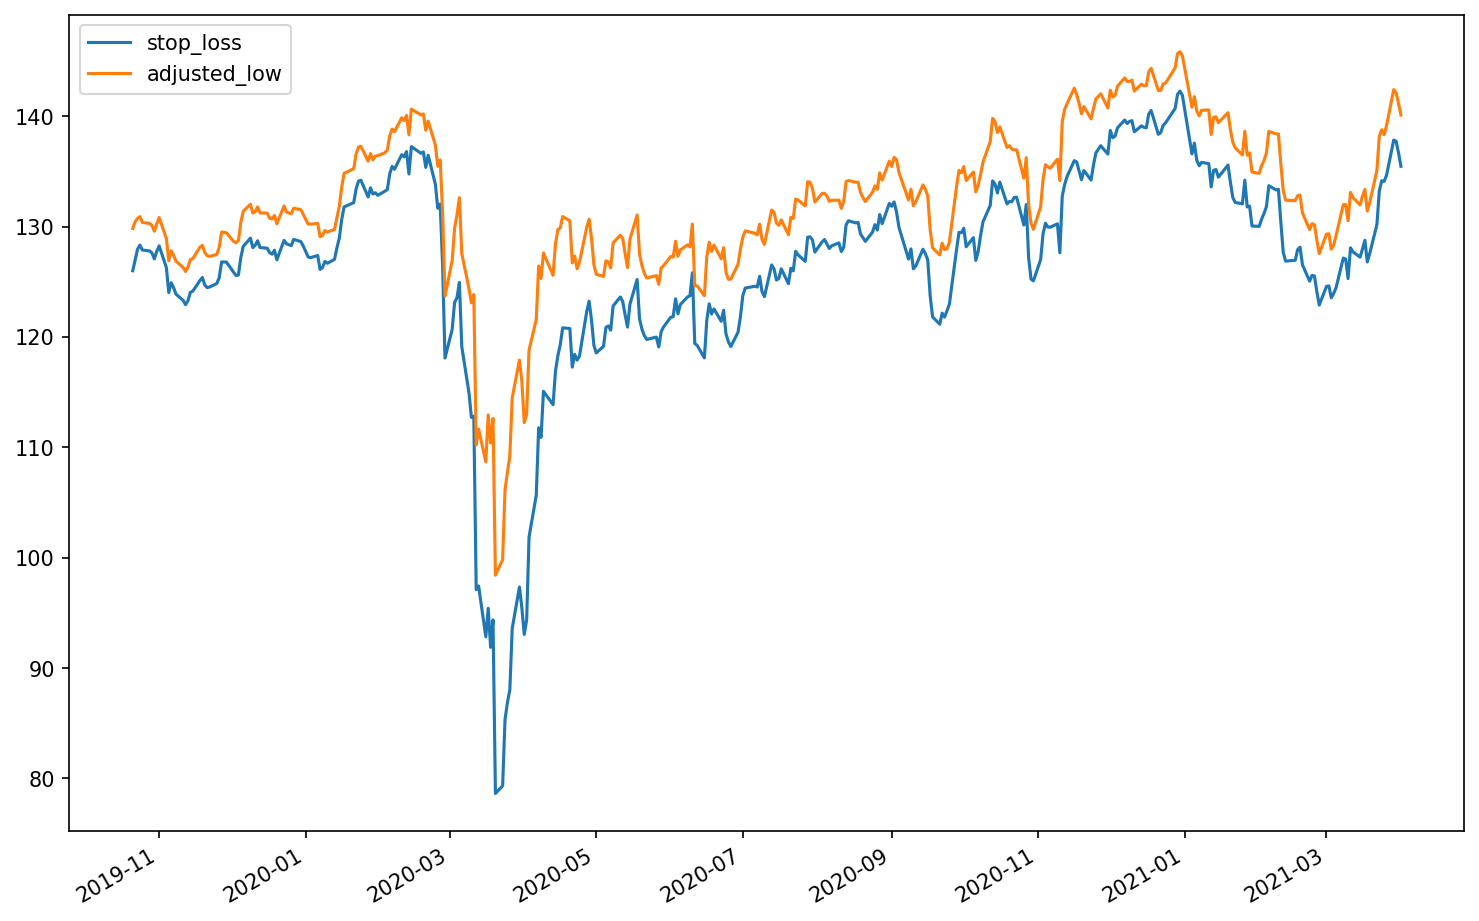

In [1017]:
x = 2  # adjust ATR factor to appropiately reduce stop loss to a more reasonable value.
df['stop_loss'] = np.clip(df.adjusted_low - x * df.ATR, a_min=0, a_max=None)
df[['stop_loss', 'adjusted_low']][-365:].plot()

In [1091]:
df['stop_loss_week'] = Finance._diff(num=Finance._rolling_min(df.adjusted_low, 7), den=df.stop_loss)
df['stop_loss_month'] = Finance._diff(num=Finance._rolling_min(df.adjusted_low, 30), den=df.stop_loss)

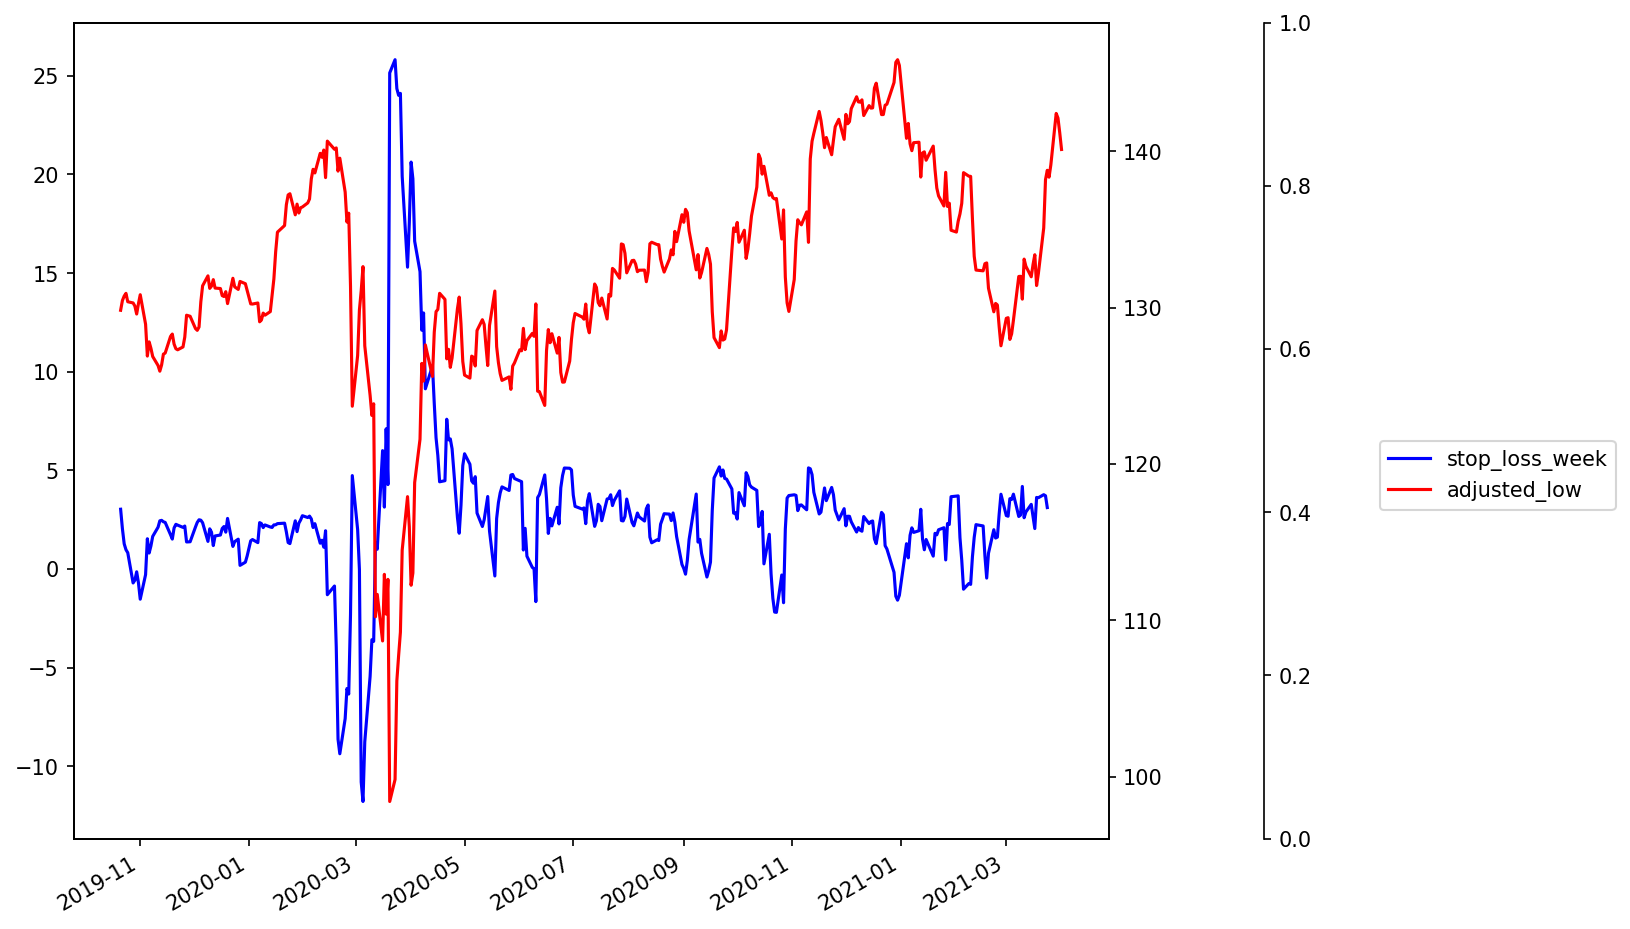

In [1098]:
plot_multi(df['stop_loss_week'][-365:], df.adjusted_low[-365:])

In [1099]:
df['stop_loss_week_flag'] = df['stop_loss_week'] <= 0
df['stop_loss_month_flag'] = df['stop_loss_month'] <= 0

<AxesSubplot:>

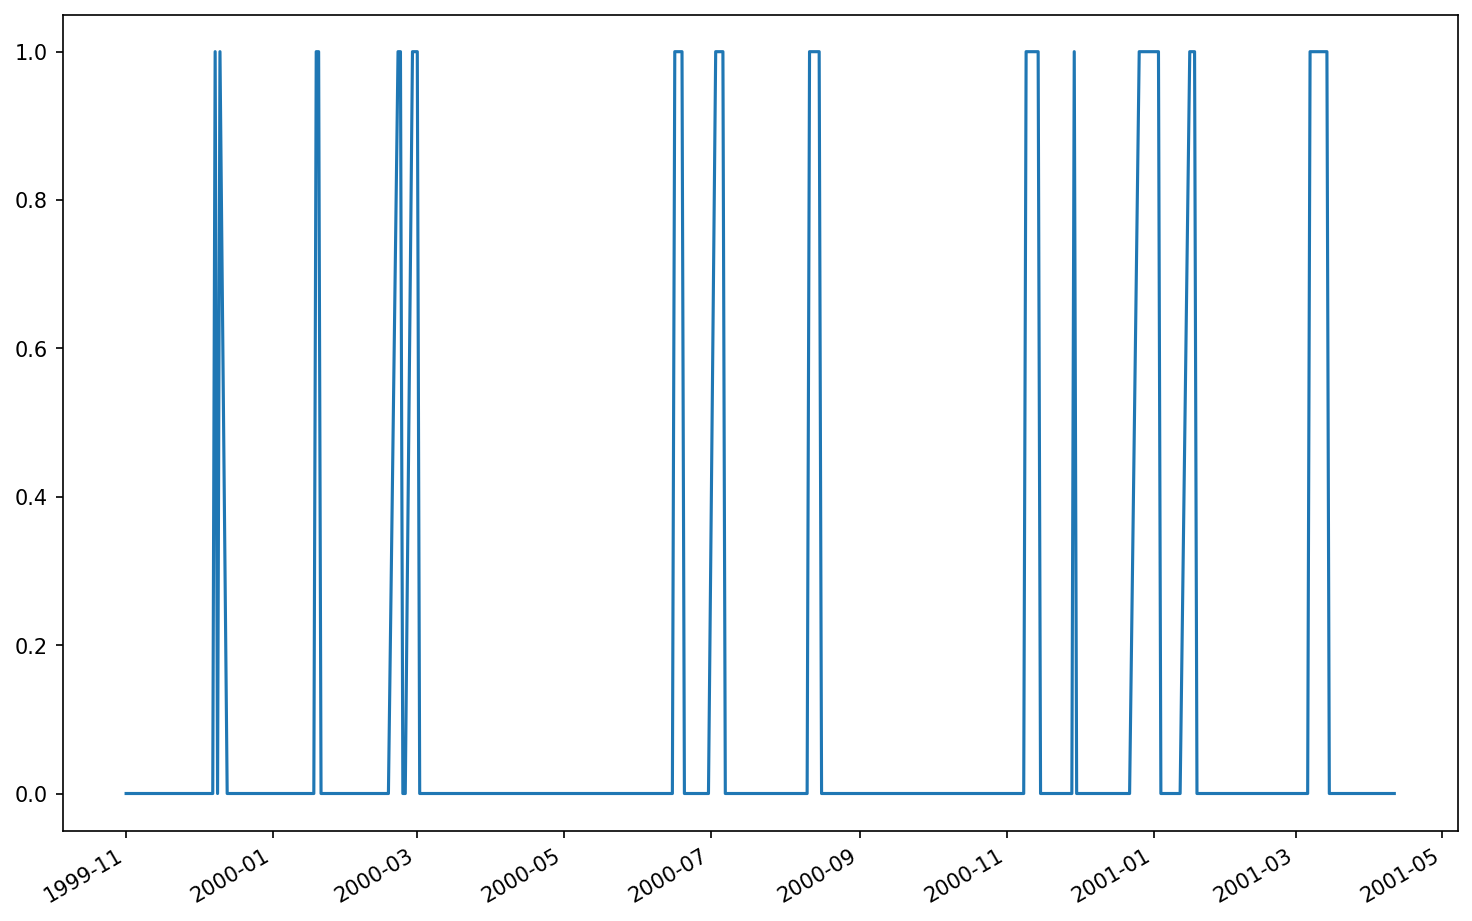

In [1104]:
df['stop_loss_week_flag'][:365].astype(int).plot()

### Create features

In [900]:
def flag_thresholds(s0, mid=50, low=30, high=70):
    """Creates flags when upper/lower thresholds are breached, which persist until mid-value crossover"""
    s1 = ((s0 < 50) == (s0 >= 50).shift(1)).astype(int).replace(0, np.nan).replace(1, 0)
    s1.loc[s0 >= 70] = 1
    s1.loc[s0 <= 30] = -1
    return s1.ffill()

In [973]:
# create new features dataframe
ft = pd.DataFrame(index=df.index)

#### RSI

In [974]:
ft['RSI'] = df['RSI'].copy()

In [975]:
ft['RSI_flag'] = flag_thresholds(ft.RSI, mid=50, low=30, high=70)

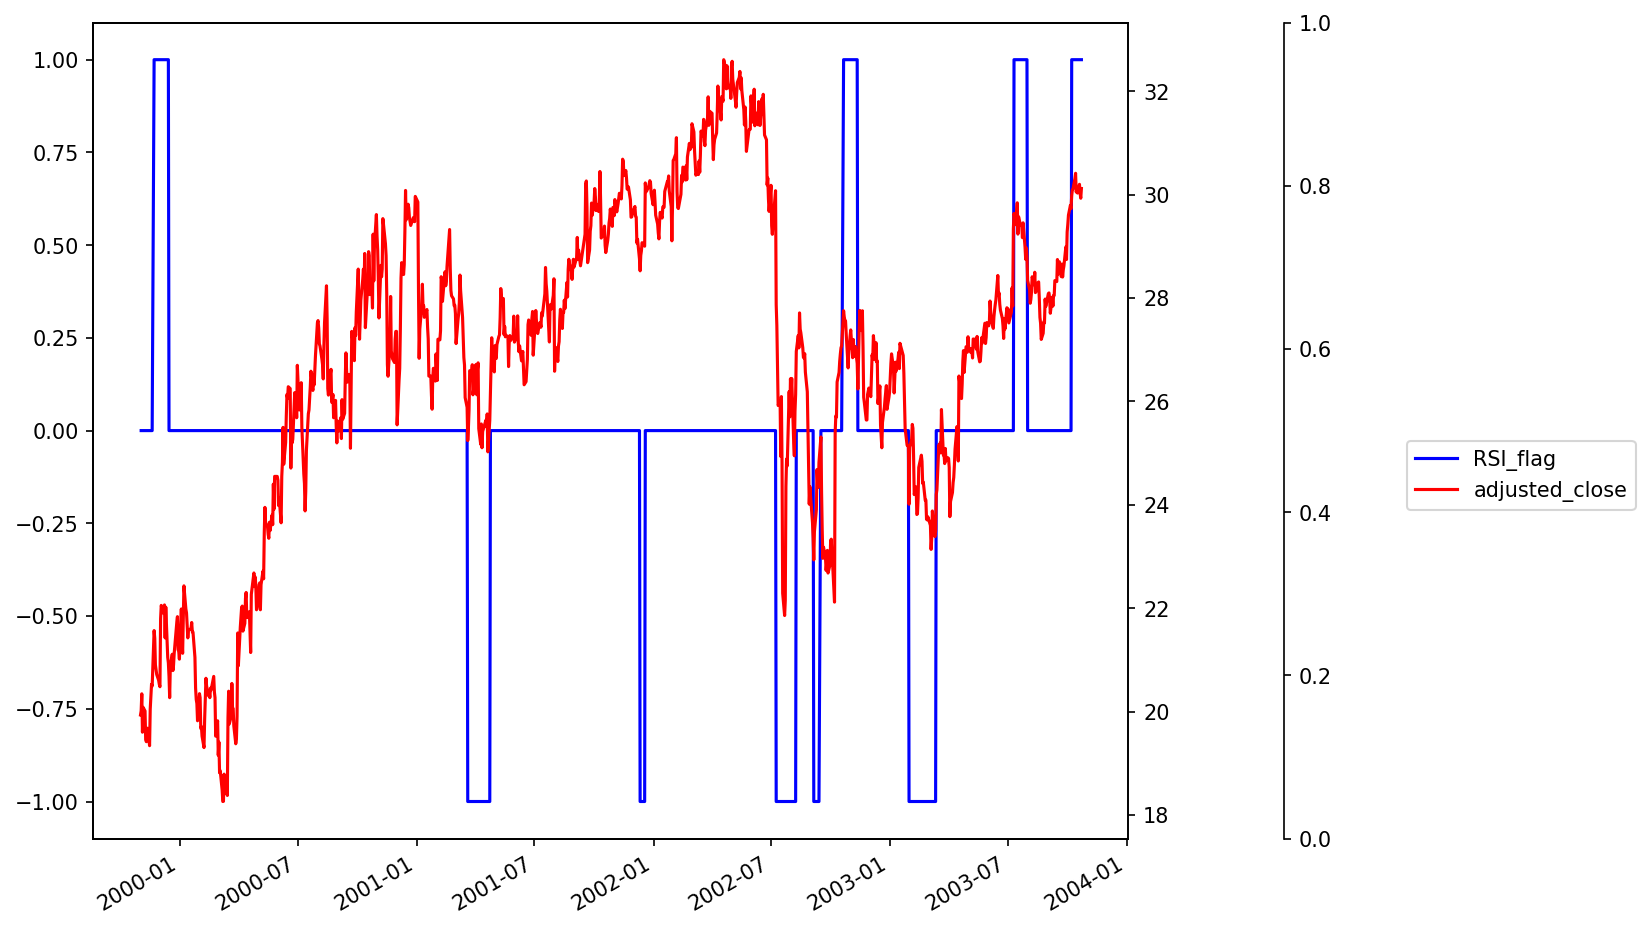

In [976]:
plot_multi(ft.RSI_flag[:1000], df.adjusted_close[:1000], )

####  OBV & OBVMA

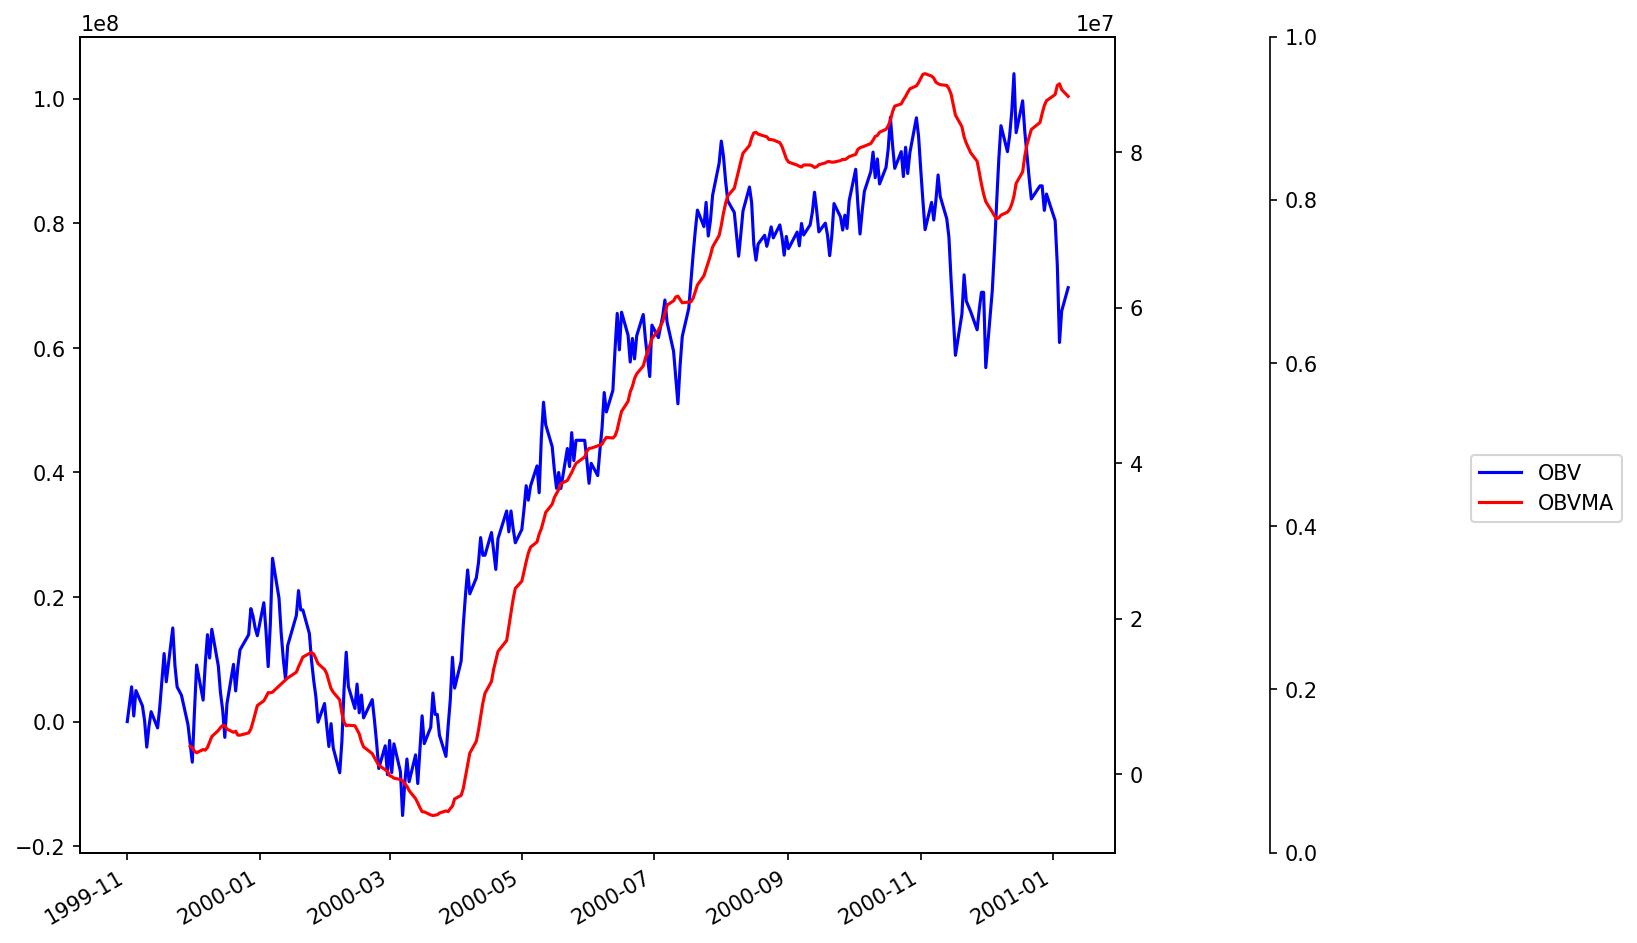

In [977]:
plot_multi(df.OBV[:300], df.OBVMA[:300])

In [978]:
ft['OBV_PO'] = Finance.PPO(df.OBV, 1, 20)

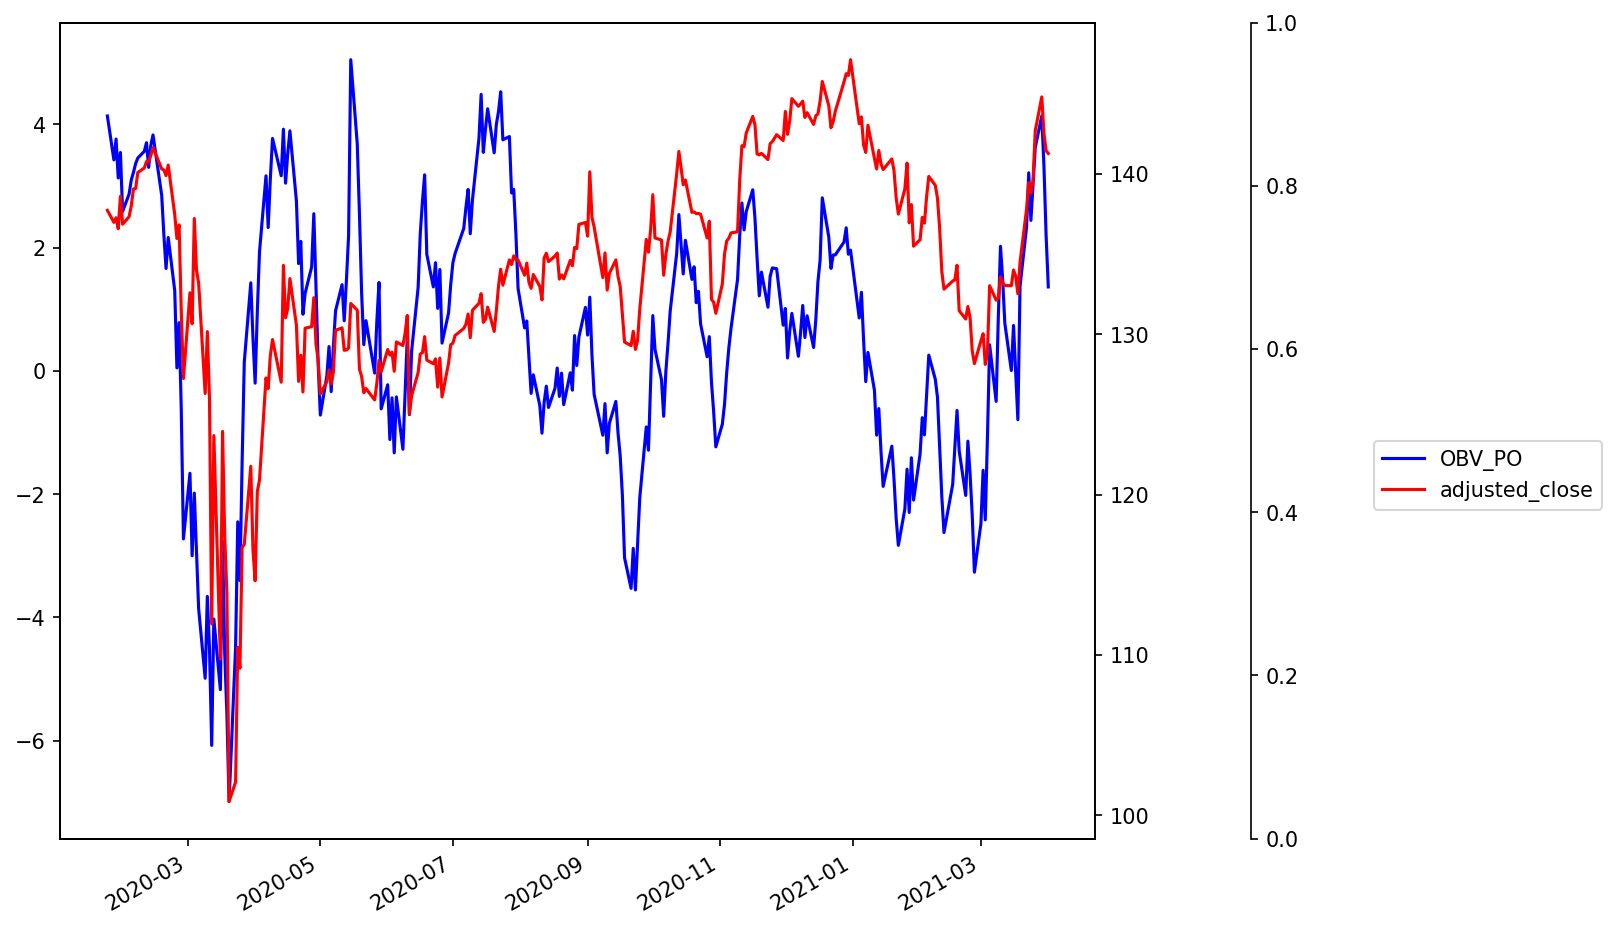

In [979]:
plot_multi(ft['OBV_PO'][-300:], df.adjusted_close[-300:])

In [980]:
ft['OBV_PO_flag'] = (ft.OBV_PO < 0) - (ft.OBV_PO >= 0).shift(1)

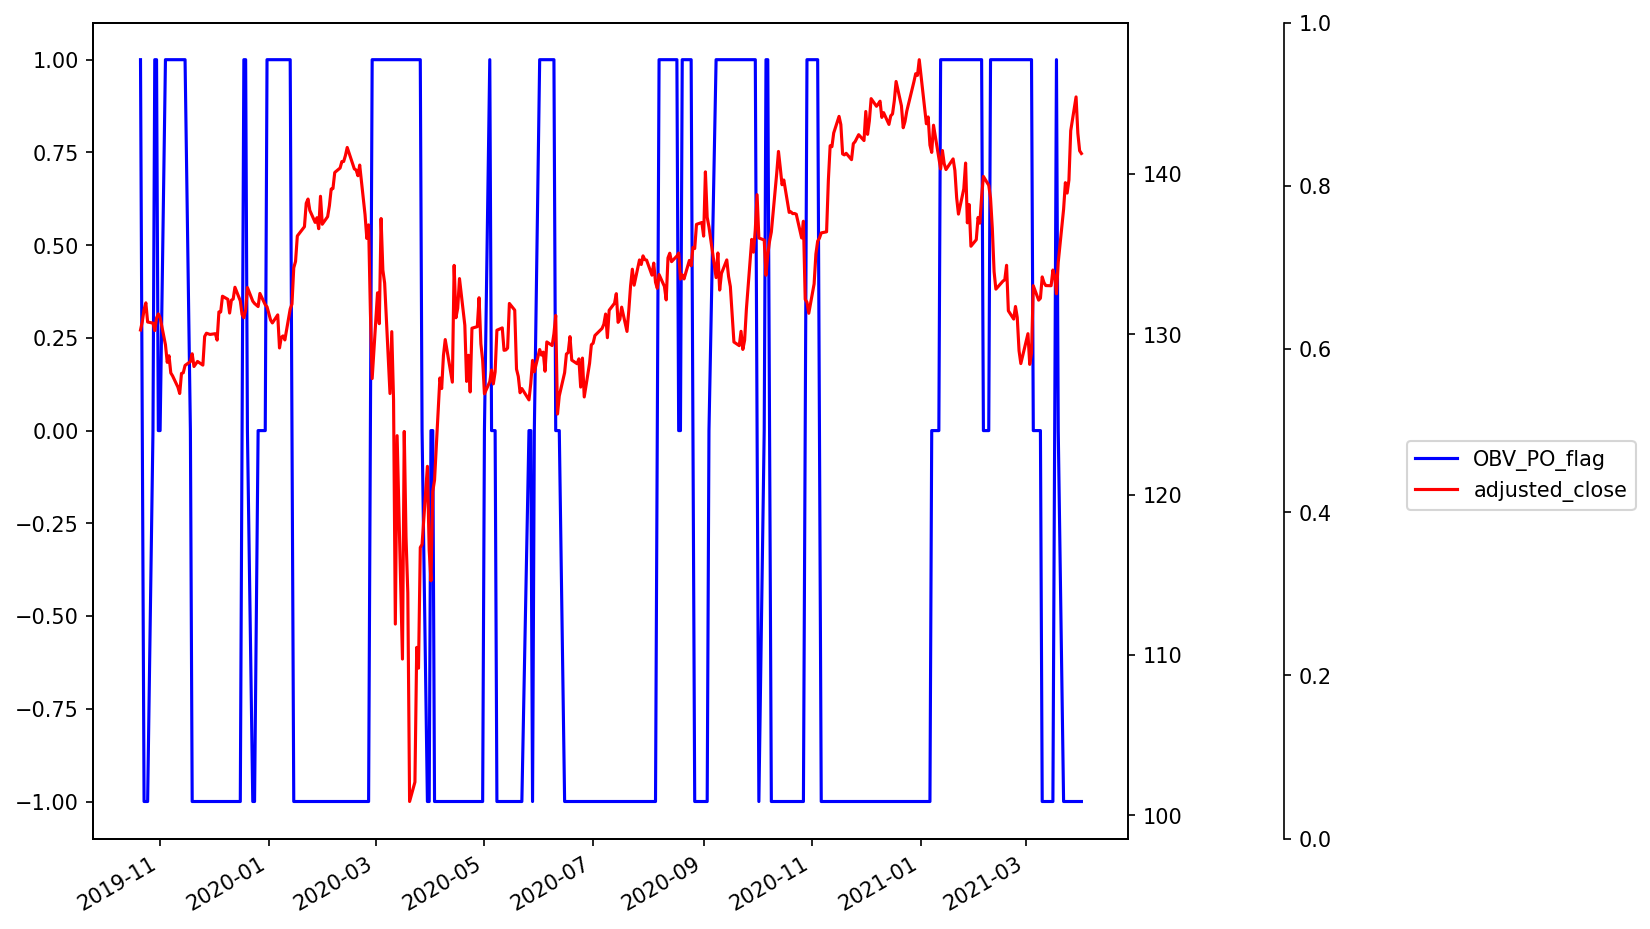

In [981]:
plot_multi(ft['OBV_PO_flag'][-365:], df.adjusted_close[-365:],)

#### Money Flow Index

In [982]:
ft['MFI'] = df['MoneyFlow'].copy()

#### PPO (Percentage Price Oscillator)

In [983]:
ft['PPO'] = df['PPO'].copy()
ft['PPO_flag'] = (ft.PPO < 0) - (ft.PPO >= 0).shift(1)

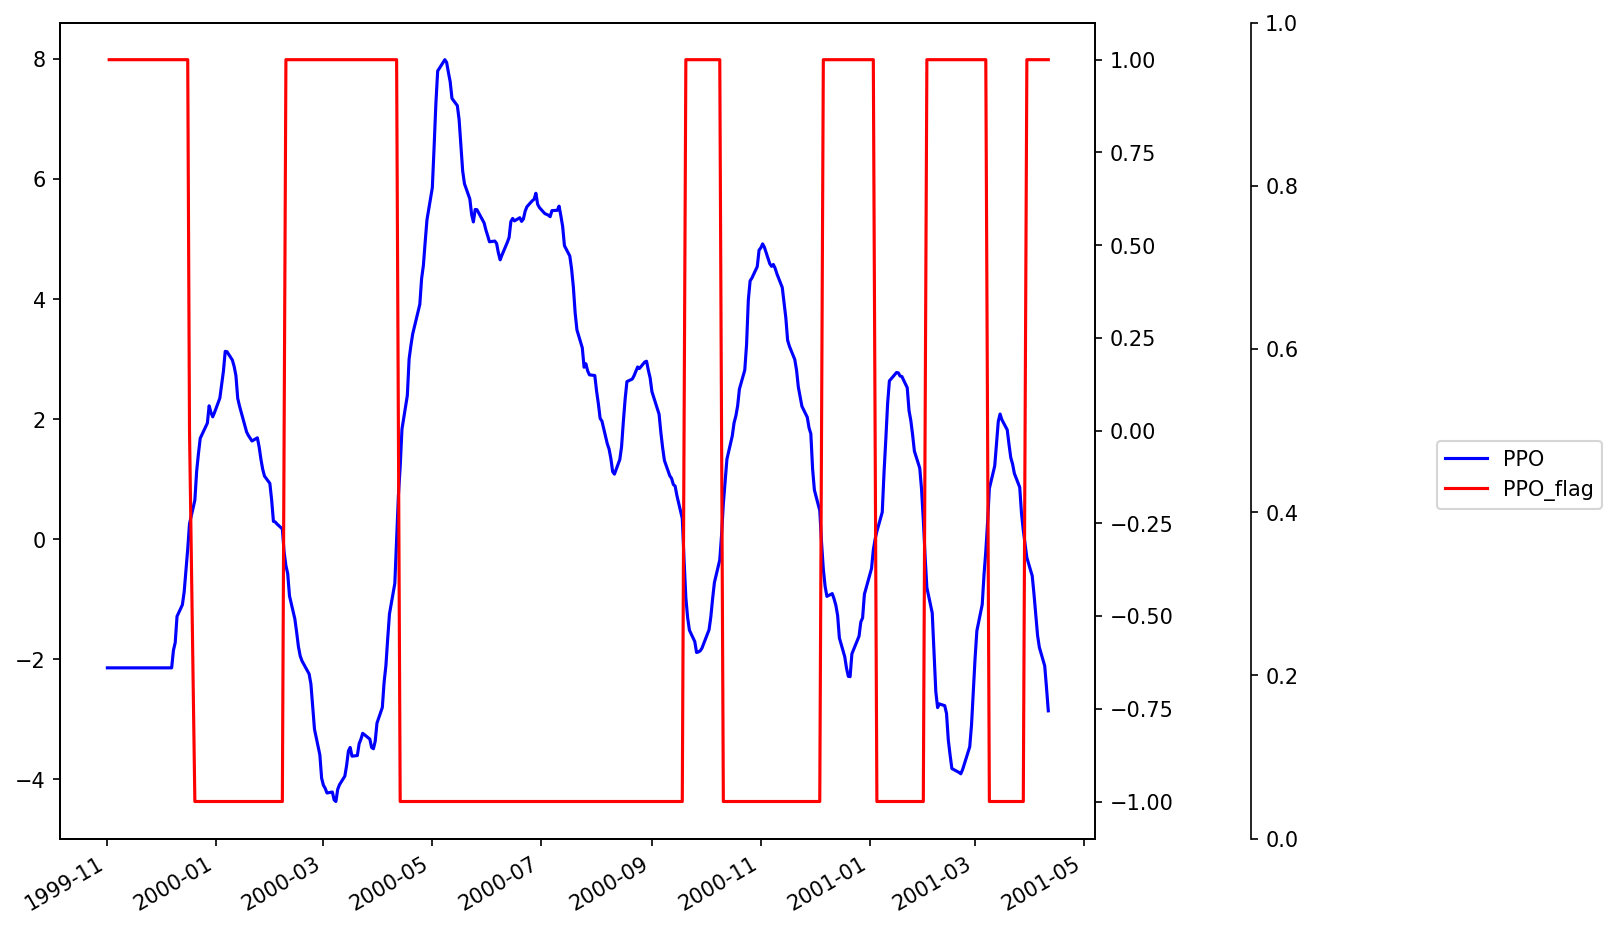

In [984]:
plot_multi(ft.PPO[:365], ft.PPO_flag[:365])

#### PROC

In [985]:
ft['PROC'] = df['PROC'].copy()
ft['PROC_flag'] = (ft.PROC < 0) - (ft.PROC >= 0).shift(1)

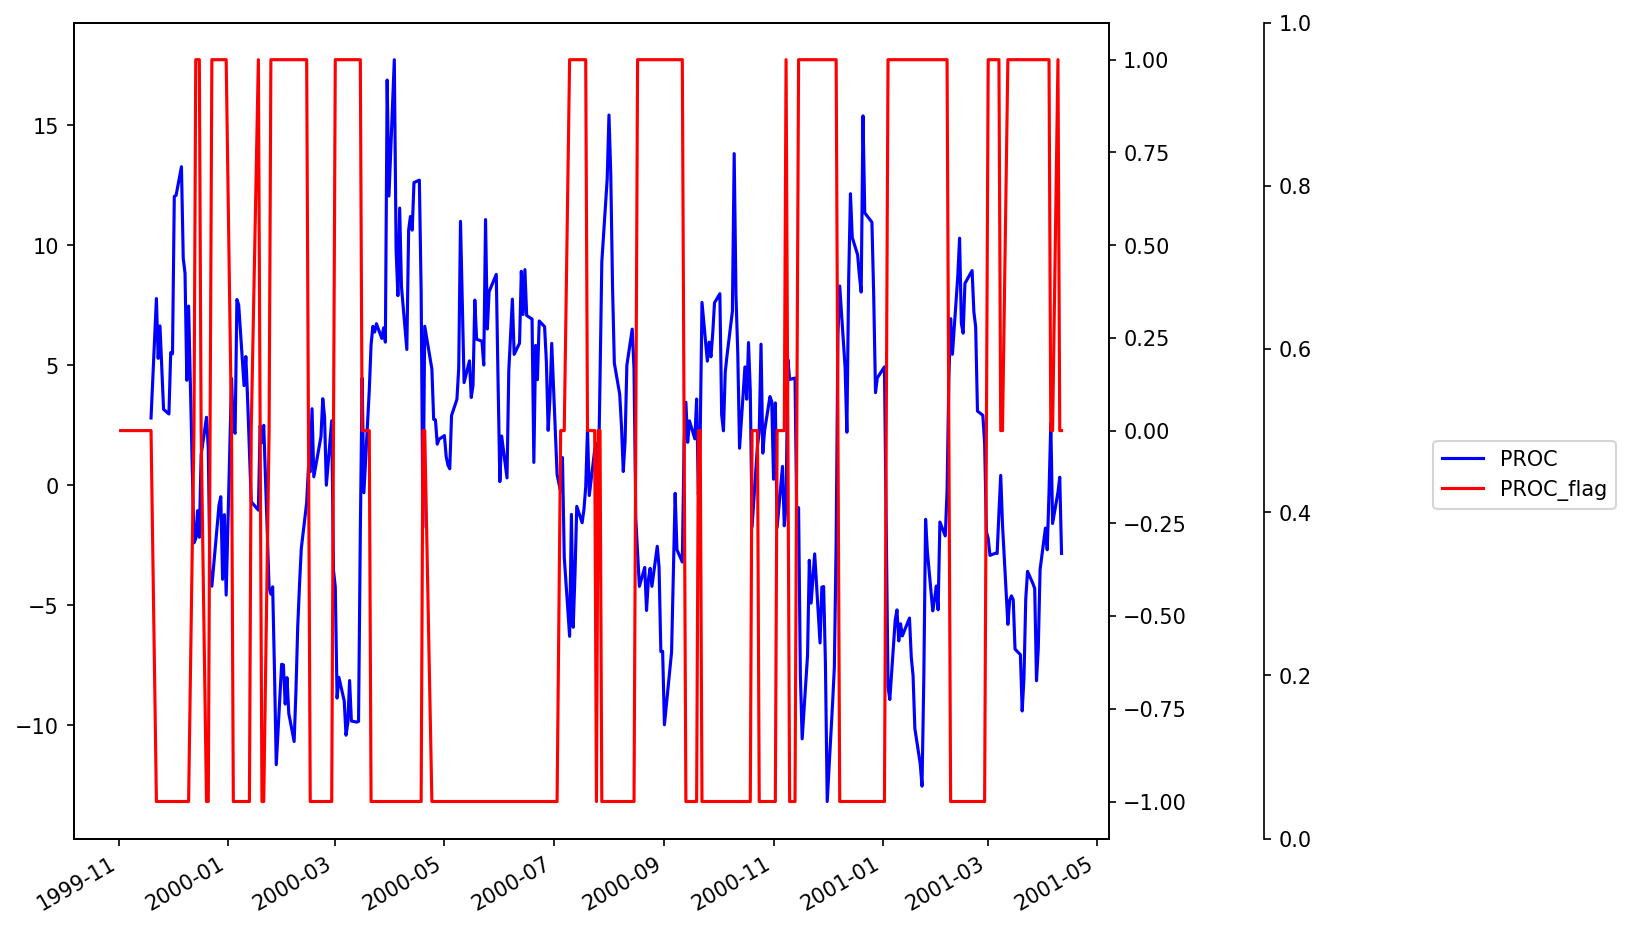

In [986]:
plot_multi(ft.PROC[:365], ft.PROC_flag[:365])

#### William's Percentage Range

In [1082]:
ft['WilliamsPctRange'] = df['WilliamsPctRange'].copy()

In [1083]:
ft['WilliamsPctRange_flag'] = flag_thresholds(ft.WilliamsPctRange * -1, mid=50, low=20, high=80)

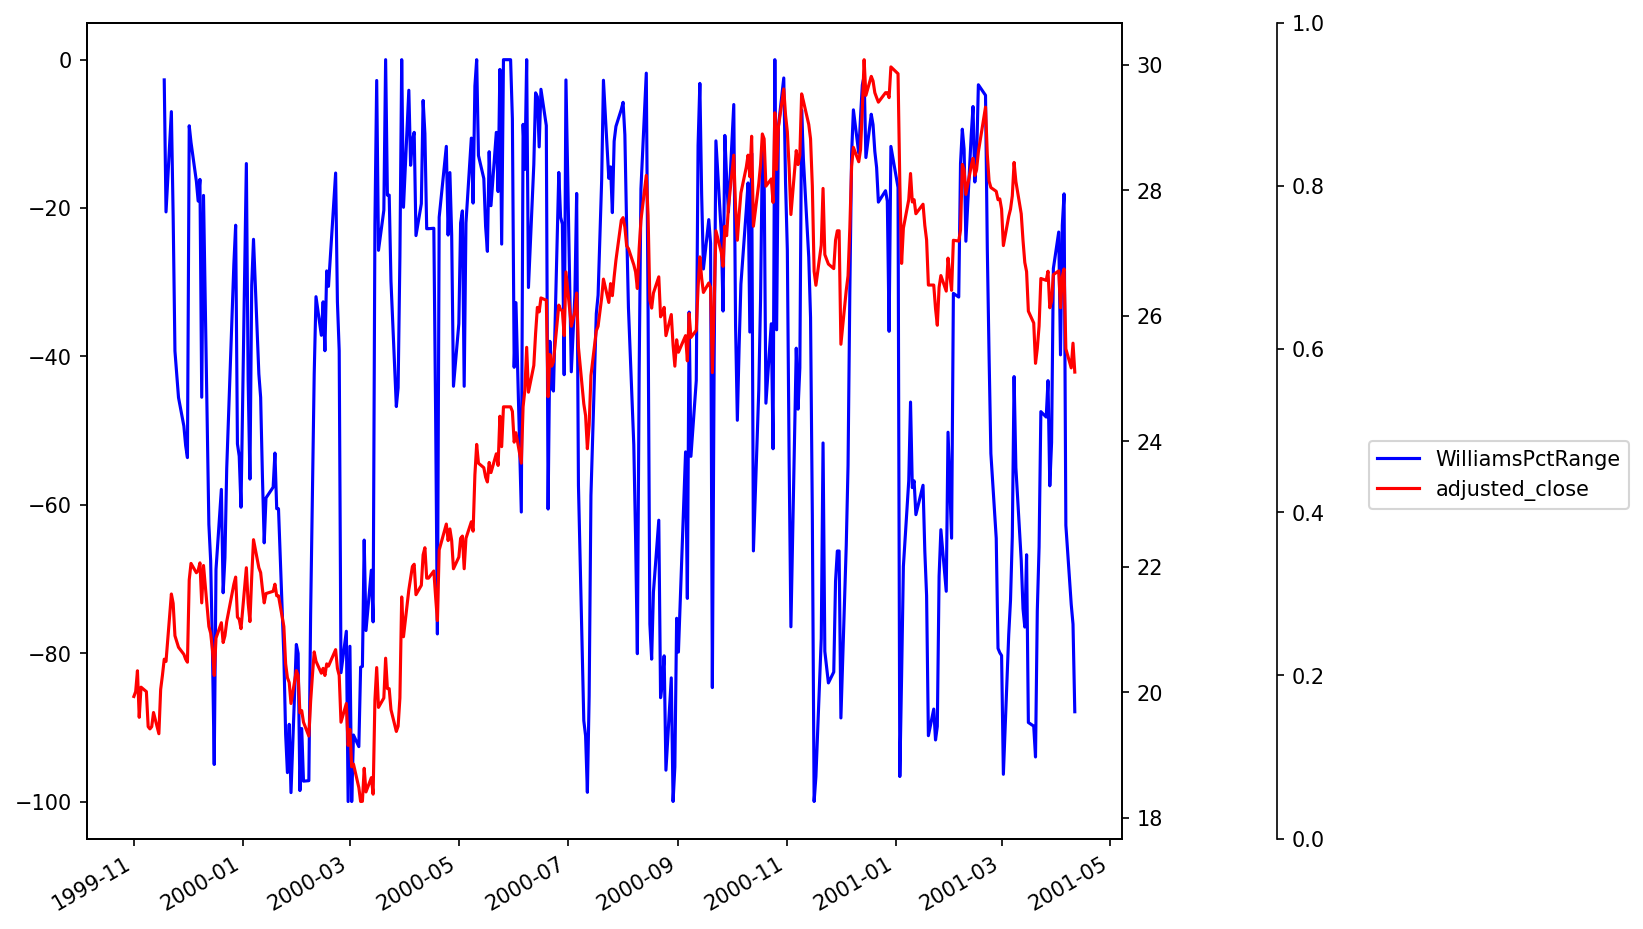

In [1087]:
plot_multi(ft['WilliamsPctRange'][:365], df['adjusted_close'][:365])

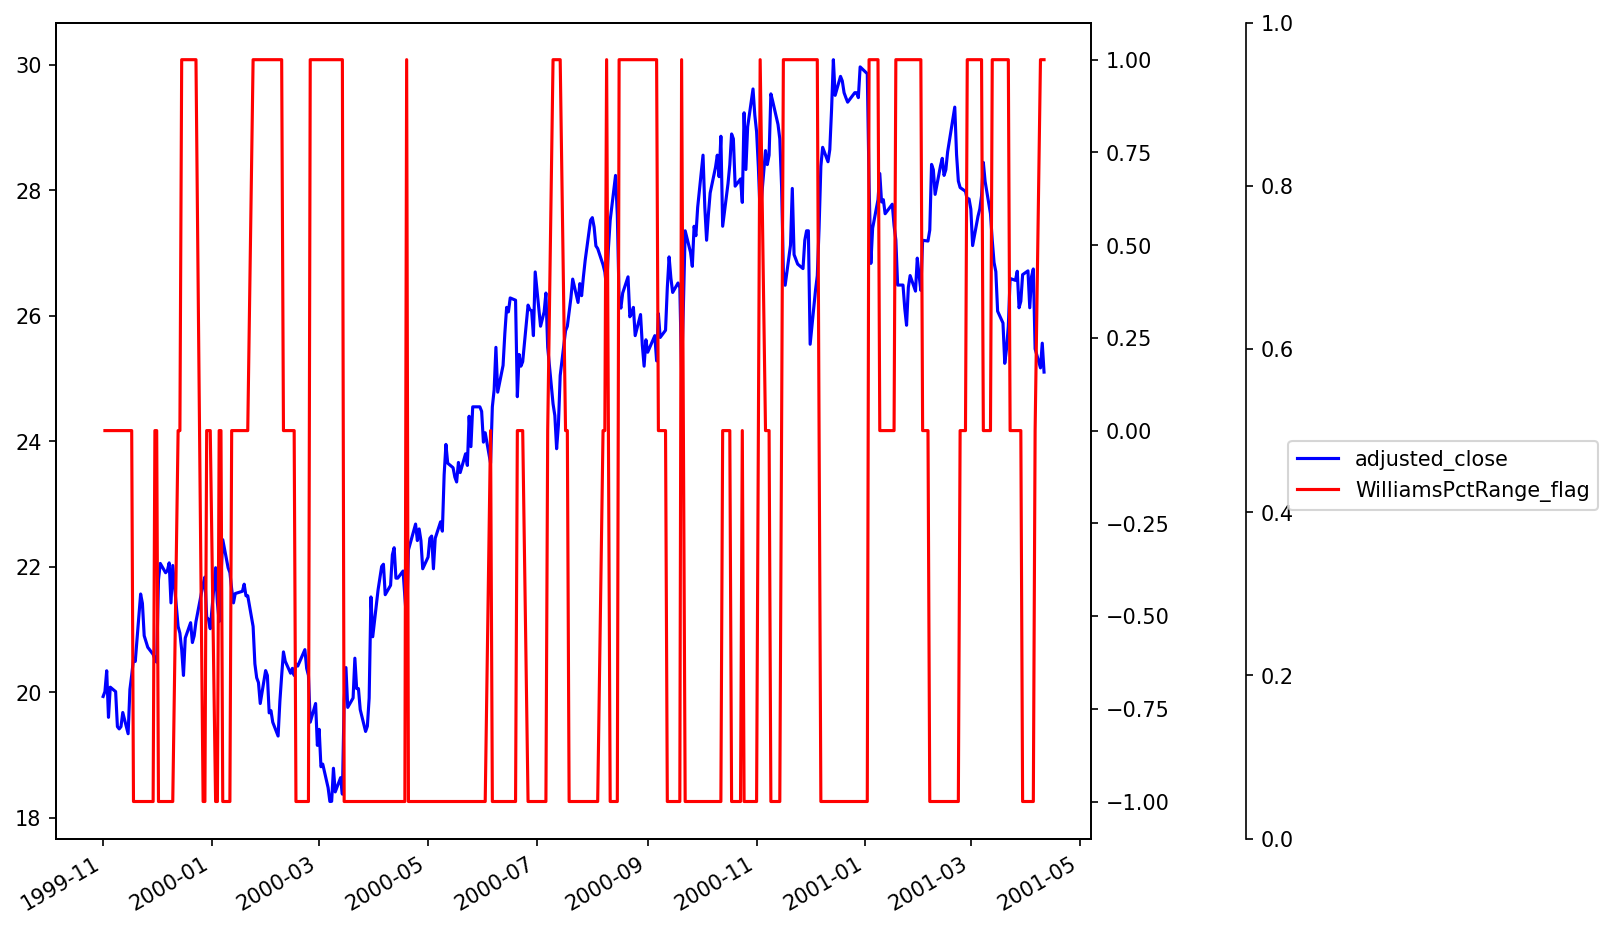

In [1084]:
plot_multi(df.adjusted_close[:365], ft.WilliamsPctRange_flag[:365])

#### CCI

In [990]:
ft['CCI'] = df['CCI'].copy()

In [991]:
ft['CCI_flag'] = flag_thresholds(ft.CCI, mid=0, low=-100, high=100)

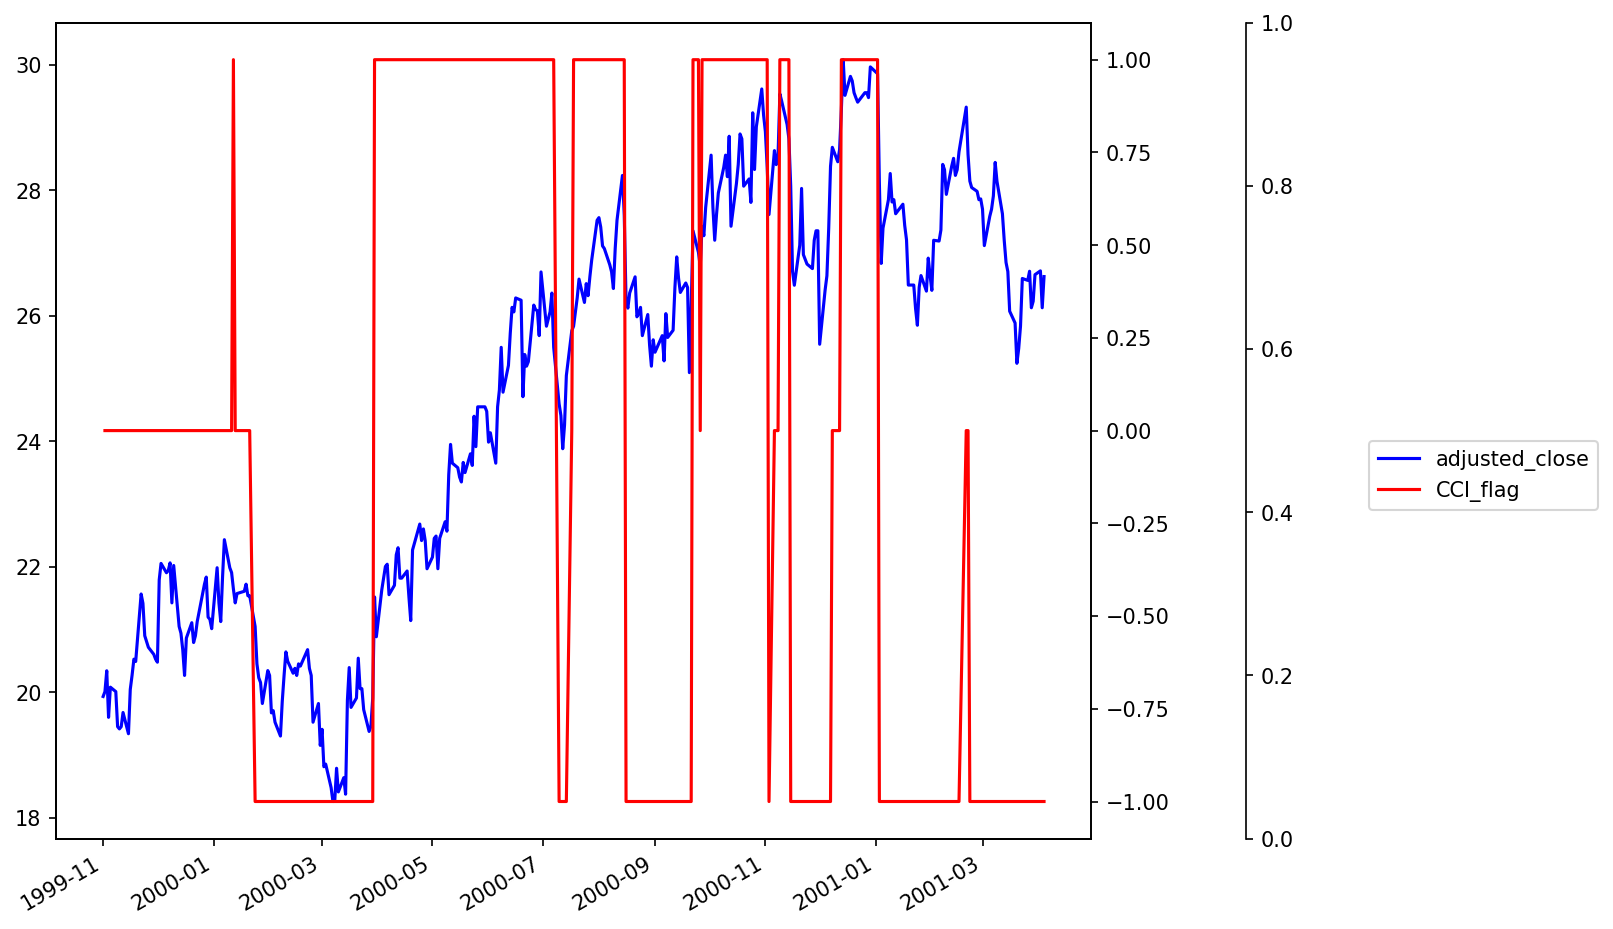

In [992]:
plot_multi(df.adjusted_close[:360], ft.CCI_flag[:360])

#### PE ratio

In [993]:
ft['PE_PO'] = df['PE_PO'].copy()
ft['PE_PO_flag'] = (ft.PE_PO < 0) - (ft.PE_PO >= 0).shift(1)

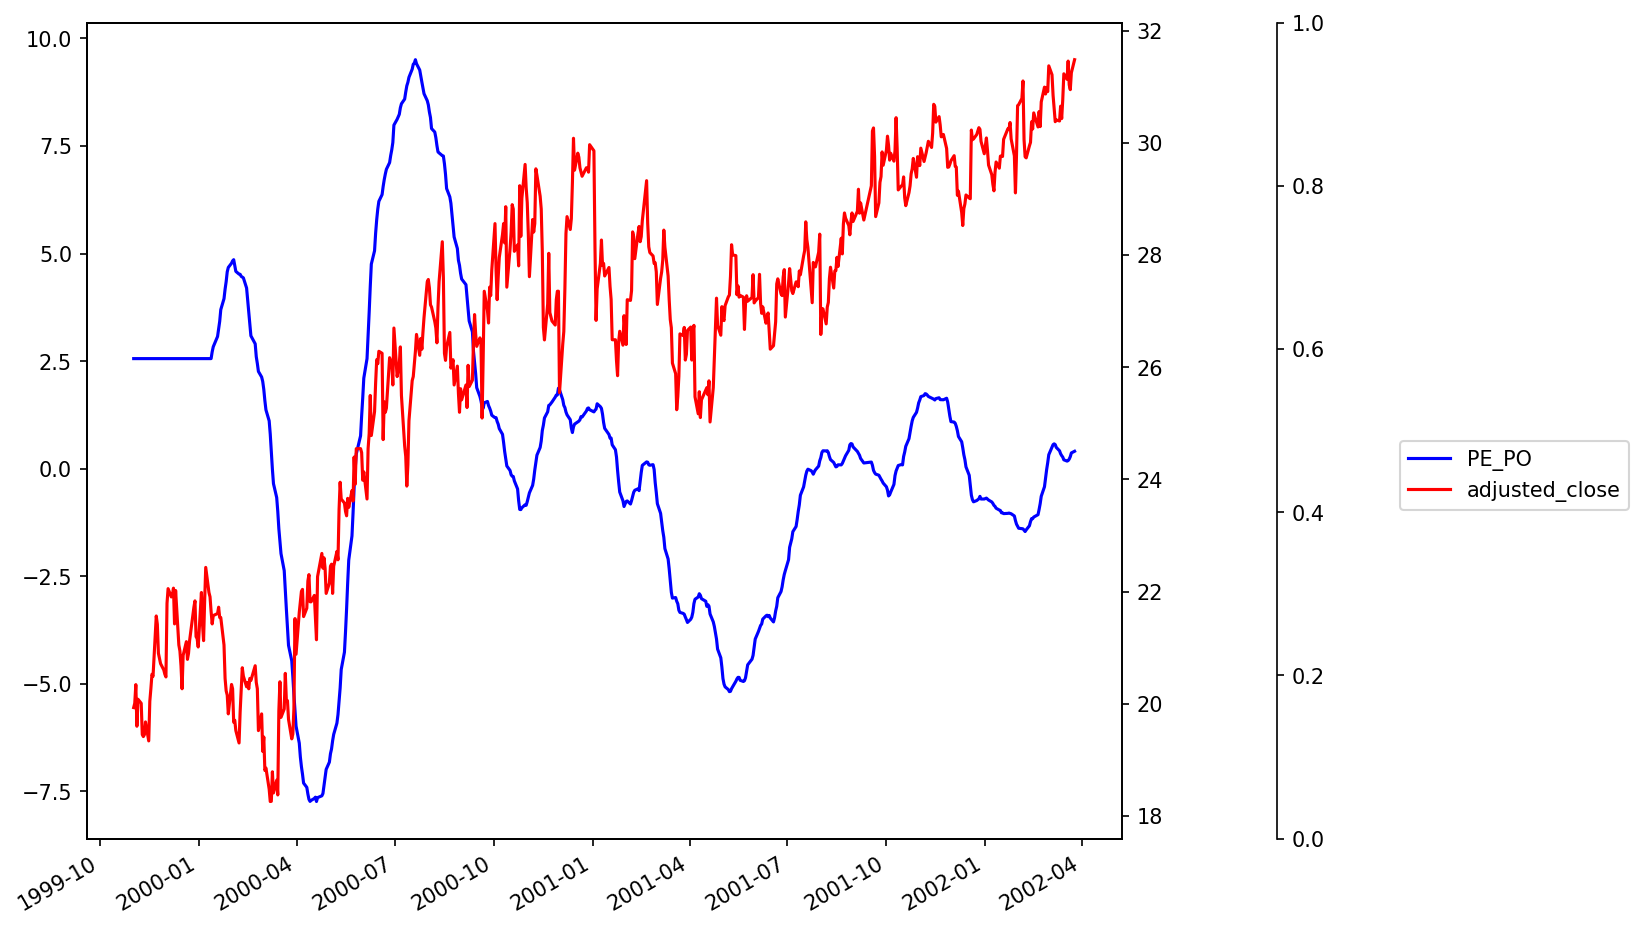

In [994]:
plot_multi(ft.PE_PO[:600], df.adjusted_close[:600])

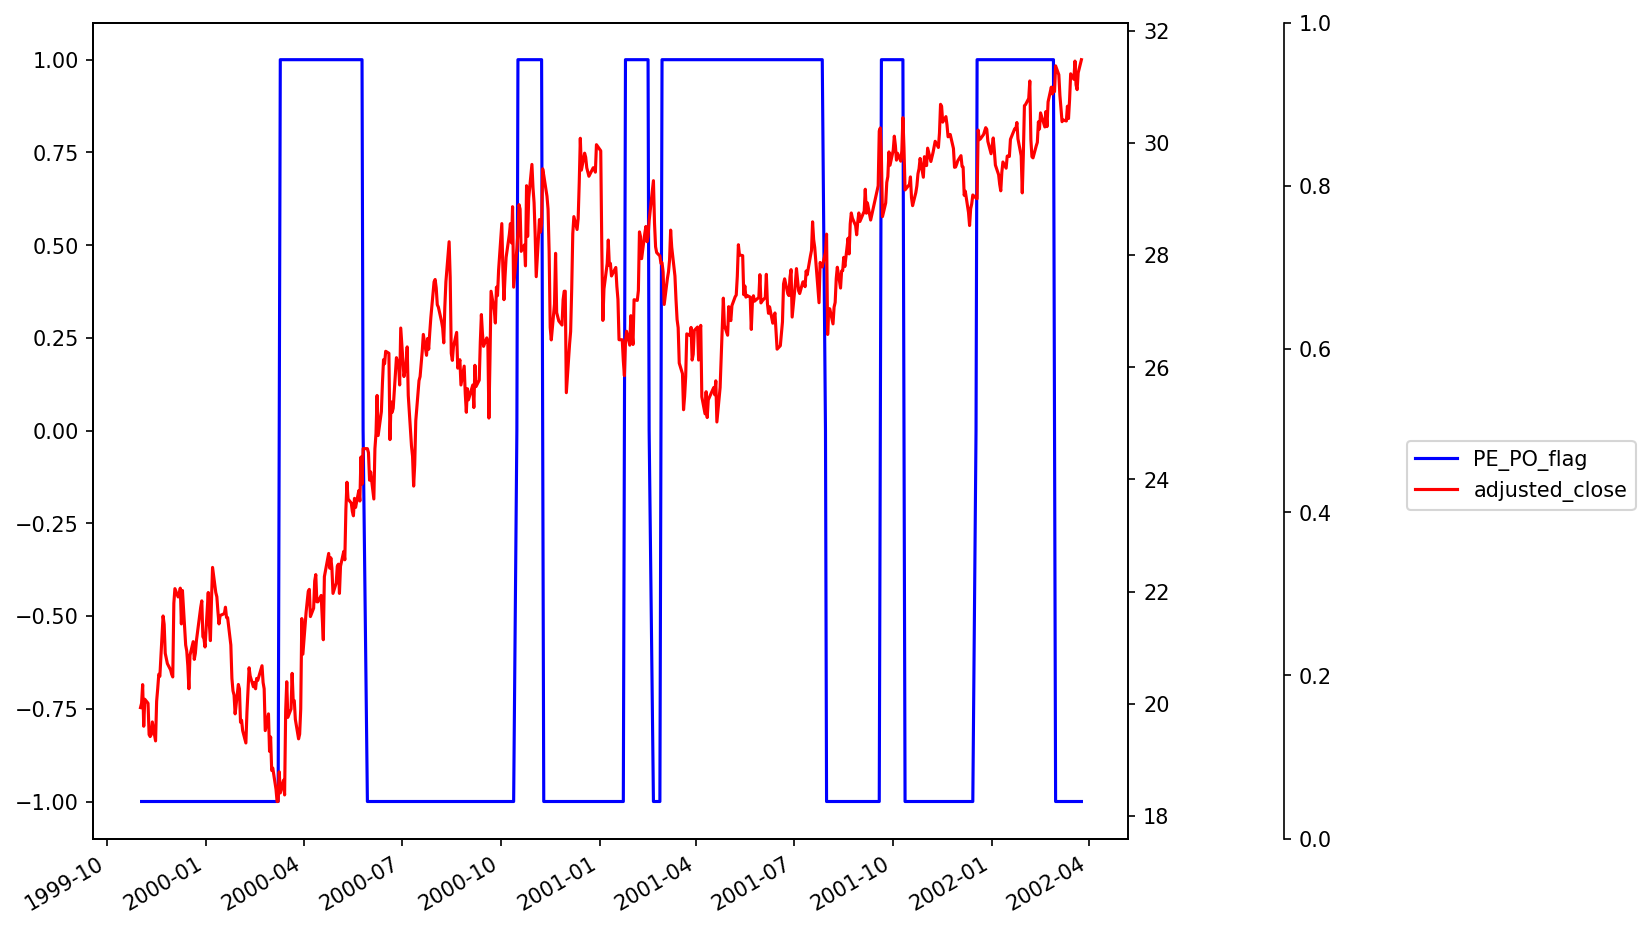

In [995]:
plot_multi(ft.PE_PO_flag[:600], df.adjusted_close[:600])

#### EPS

In [996]:
df

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,adjusted_open,adjusted_high,adjusted_low,adjusted_volume,dividend_pct,dividend_yield,EPS_ttm,EPS_surprise_pct,reported_date,PE,daily,weekly,monthly,RSI,OBV,OBVMA,MoneyFlow,PPO,RelativeEMA_14,RelativeEMA_28,EMACD,PROC,WilliamsPctRange,CCI,STOK,PEMA,PE_PPO,dividend_PPO,ATR,stop_loss,PE_PO,dividend_PO
1999-11-01,34.44,34.56,33.560,33.56,19.933384,3635000.0,0.0,1.0,20.456071,20.527347,19.933384,3635000.0,0.0,0.000000,1.14,0.030303,1999-10-06,17.485425,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-2.141394,NaN,NaN,-2.141394,NaN,NaN,NaN,NaN,NaN,2.558643,-49.749014,NaN,NaN,2.558643,-49.749014
1999-11-02,33.63,34.31,33.560,33.69,20.010599,2682900.0,0.0,1.0,19.974962,20.378856,19.933384,2682900.0,0.0,0.000000,1.14,0.030303,1999-10-06,17.553157,0.003874,NaN,NaN,NaN,2682900.0,NaN,NaN,-2.141394,19.906294,20.405896,-2.141394,NaN,NaN,NaN,NaN,NaN,2.558643,-49.749014,NaN,NaN,2.558643,-49.749014
1999-11-03,33.81,34.31,33.750,34.25,20.343219,2898500.0,0.0,1.0,20.081875,20.378856,20.046237,2898500.0,0.0,0.000000,1.14,0.030303,1999-10-06,17.844929,0.016622,NaN,NaN,NaN,5581400.0,NaN,NaN,-2.141394,19.950643,20.428836,-2.141394,NaN,NaN,NaN,NaN,NaN,2.558643,-49.749014,NaN,NaN,2.558643,-49.749014
1999-11-04,34.25,34.56,32.060,33.00,19.600765,4683900.0,0.0,1.0,20.343219,20.527347,19.042440,4683900.0,0.0,0.000000,1.14,0.030303,1999-10-06,17.193654,-0.036496,NaN,NaN,NaN,897500.0,NaN,NaN,-2.141394,19.851649,20.377632,-2.141394,NaN,NaN,NaN,NaN,NaN,2.558643,-49.749014,NaN,NaN,2.558643,-49.749014
1999-11-05,33.00,34.06,33.000,33.81,20.081875,4080100.0,0.0,1.0,19.600765,20.230366,19.600765,4080100.0,0.0,0.000000,1.14,0.030303,1999-10-06,17.615680,0.024545,NaN,NaN,NaN,4977600.0,NaN,NaN,-2.141394,19.915797,20.410812,-2.141394,NaN,NaN,NaN,NaN,NaN,2.558643,-49.749014,NaN,NaN,2.558643,-49.749014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,139.62,143.00,139.130,142.70,142.700000,6785599.0,0.0,1.0,139.620000,143.000000,139.130000,6785599.0,0.0,0.030183,5.52,0.007056,2021-02-11,25.851449,0.021987,0.067954,0.065663,71.289722,777905867.0,7.510159e+08,50.766936,-2.509118,135.305012,133.091979,-2.509118,7.999697,-2.407705,115.330455,97.592295,24.529815,-2.775389,0.435002,2.240000,138.220000,-2.775389,0.435002
2021-03-29,142.87,144.96,142.415,144.81,144.810000,6105770.0,0.0,1.0,142.870000,144.960000,142.415000,6105770.0,0.0,0.030183,5.52,0.007056,2021-02-11,26.233696,0.014786,0.092658,0.090306,74.418330,784011637.0,7.533636e+08,49.536542,-2.190787,136.105945,133.385350,-2.190787,9.497164,-1.040222,158.991638,98.959778,24.532418,-2.910197,0.467900,2.285357,140.239286,-2.910197,0.467900
2021-03-30,143.68,144.75,142.120,142.54,142.540000,4372866.0,0.0,1.0,143.680000,144.750000,142.120000,4372866.0,0.0,0.030183,5.52,0.007056,2021-02-11,25.822464,-0.015676,0.059777,0.069142,66.076031,779638771.0,7.557522e+08,45.805968,-1.925782,136.427353,133.418620,-1.925782,6.707591,-17.859779,136.292597,82.140221,24.545660,-3.027166,0.501790,2.196786,138.146429,-3.027166,0.501790
2021-03-31,143.32,143.33,141.170,141.45,141.450000,6257943.0,0.0,1.0,143.320000,143.330000,141.170000,6257943.0,0.0,0.030183,5.52,0.007056,2021-02-11,25.625000,-0.007647,0.026488,0.060335,62.455582,773380828.0,7.576415e+08,50.003339,-1.611009,136.734945,133.447502,-1.611009,6.177751,-25.904059,112.515894,74.095941,24.552012,-3.156825,0.536695,2.245357,136.959286,-3.156825,0.536695


In [997]:
ft['EPS_report_flag'] = df.reported_date == df.index
ft['EPS_estimate_flag'] = df.EPS_surprise_pct > 0
ft['EPS_PO'] = Finance.PPO(df.EPS_ttm, 50, 100)

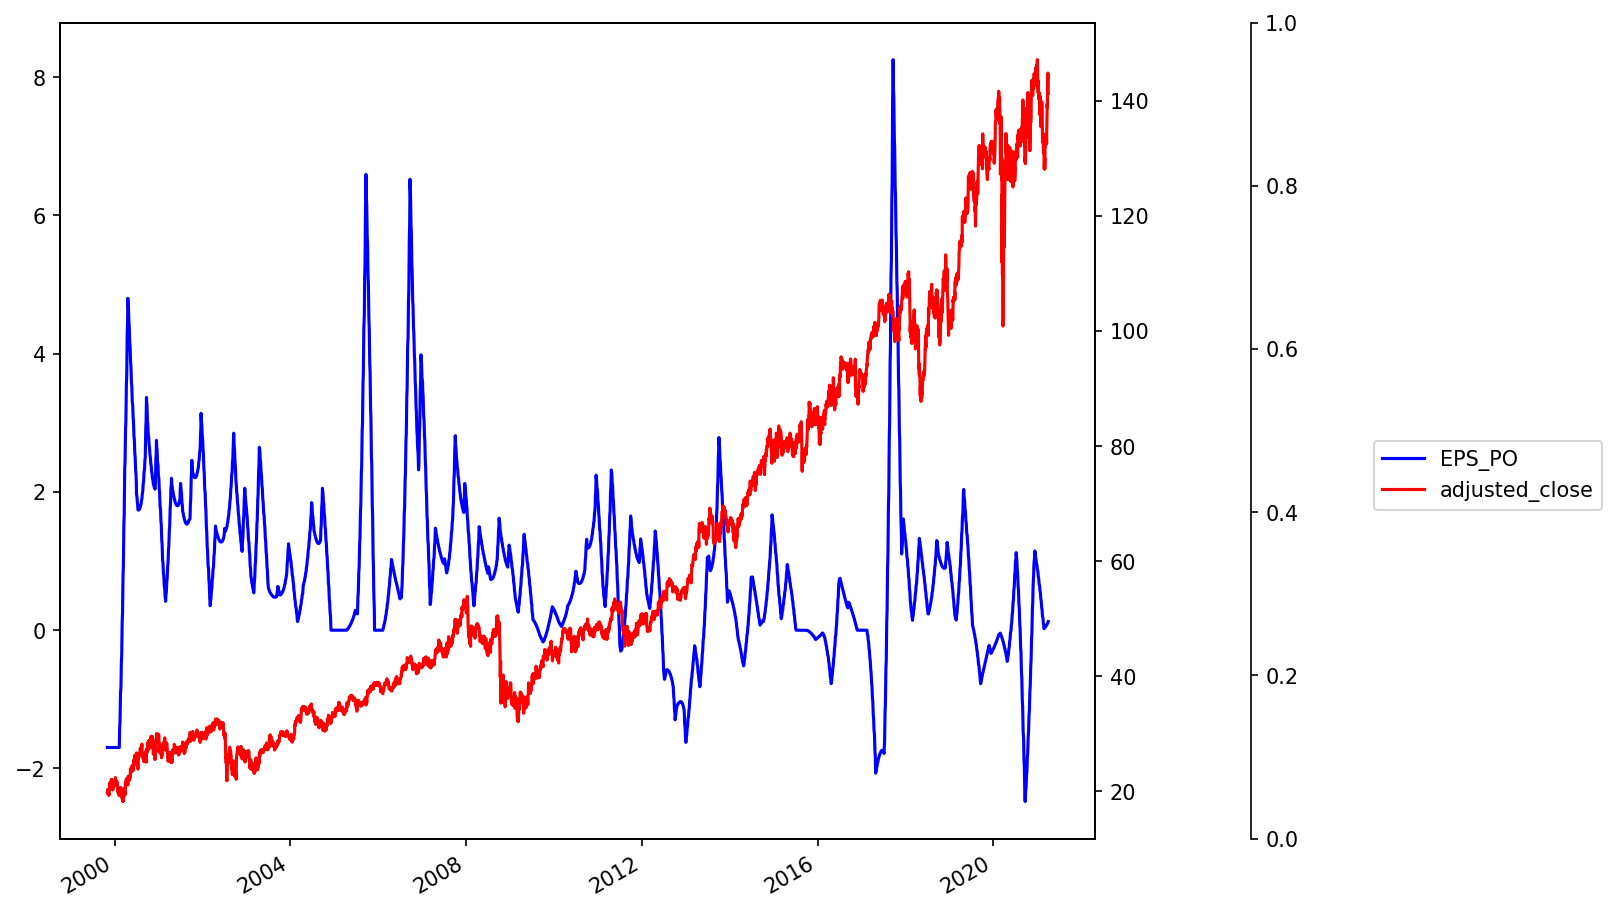

In [998]:
plot_multi(ft['EPS_PO'], df.adjusted_close)

#### Dividends

In [999]:
ft['dividend_ex_flag'] = df.dividend > 0
ft['dividend_PO'] = df['dividend_PO']
ft['dividend_PO_flag'] = (ft.dividend_PO < 0) - (ft.dividend_PO >= 0).shift(1)

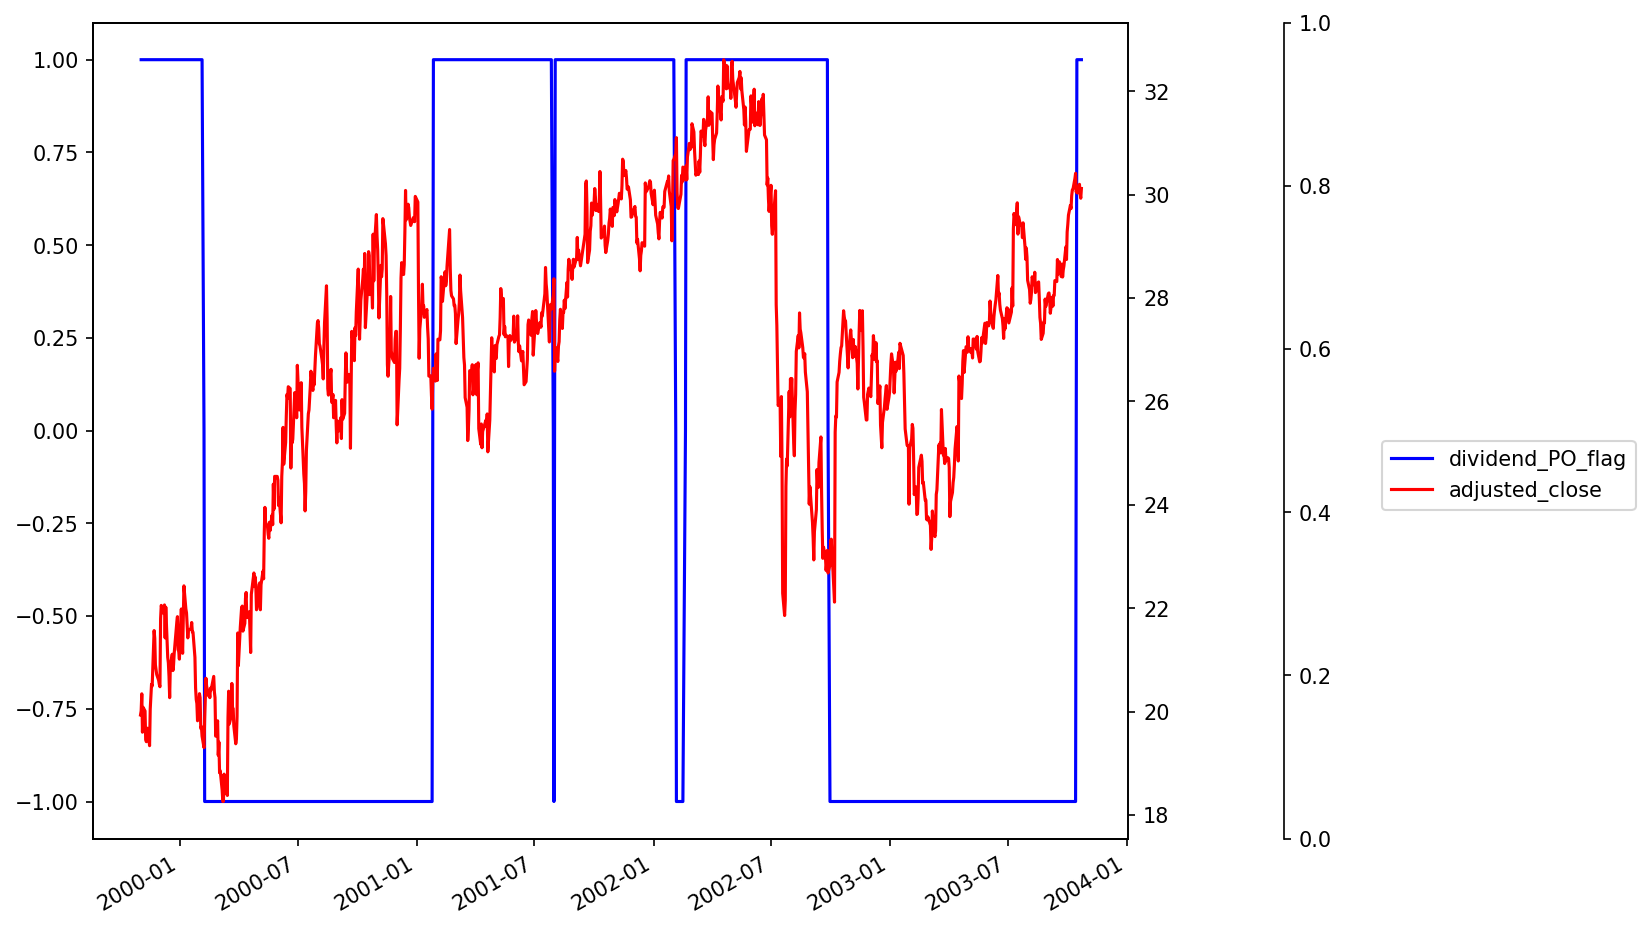

In [1000]:
plot_multi(ft.dividend_PO_flag[:1000], df.adjusted_close[:1000])

## ML

In [1199]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

### Prep data

In [1107]:
# trim the first year from the ft and df data
ft2 = ft[365:].copy()
df2 = df[365:].copy()

In [1123]:
# convert object data types to numeric data type
ft2[ft2.columns] = ft2[ft2.columns].apply(pd.to_numeric, errors='raise')
ft2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5024 entries, 2001-04-12 to 2021-04-01
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RSI                    5024 non-null   float64
 1   RSI_flag               5024 non-null   float64
 2   OBV_PO                 5024 non-null   float64
 3   OBV_PO_flag            5024 non-null   int64  
 4   MFI                    5024 non-null   float64
 5   PPO                    5024 non-null   float64
 6   PPO_flag               5024 non-null   int64  
 7   PROC                   5024 non-null   float64
 8   PROC_flag              5024 non-null   int64  
 9   WilliamsPctRange       5024 non-null   float64
 10  WilliamsPctRange_flag  5024 non-null   float64
 11  CCI                    5024 non-null   float64
 12  CCI_flag               5024 non-null   float64
 13  PE_PO                  5024 non-null   float64
 14  PE_PO_flag             5024 non-null  

In [1201]:
Xtrain, Xtest = ft2[:1000], ft2[1000:2000]
ytrain, ytest = df2.stop_loss_month_flag[:1000], df2.stop_loss_month_flag[1000:2000]

### XGBoost model

In [2]:
# read in data
dtrain = xgb.DMatrix(Xtrain, label=ytrain, )
dtest = xgb.DMatrix(Xtest, label=ytest, )

# specify parameters via map
param = {
    'max_depth':6, 
    'eta':0.3, 
    'min_child_weight': 0.5, 
    'gamma': 1, 
    'objective':'binary:logistic', 
    'eval_metric': 'auc', 
    'max_delta_step': 1

}
num_round = 500
bst = xgb.train(param, dtrain, num_round)

# make prediction
preds = bst.predict(dtest)

NameError: name 'xgb' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

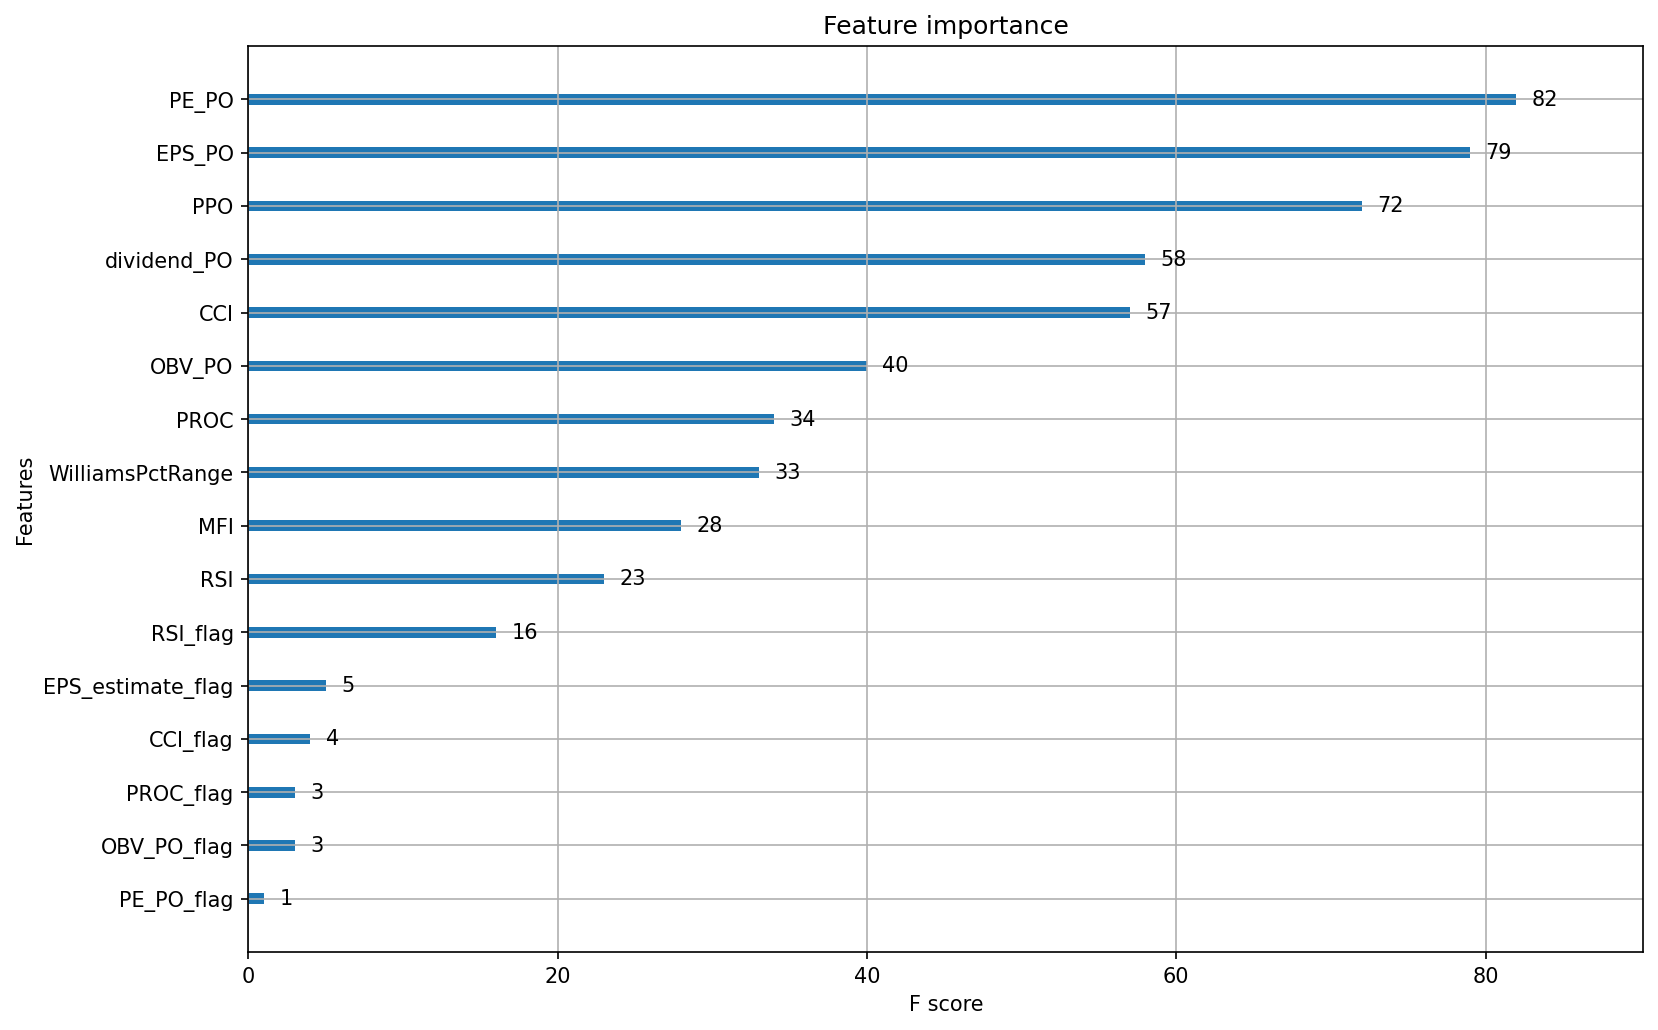

In [1203]:
xgb.plot_importance(bst)

<AxesSubplot:>

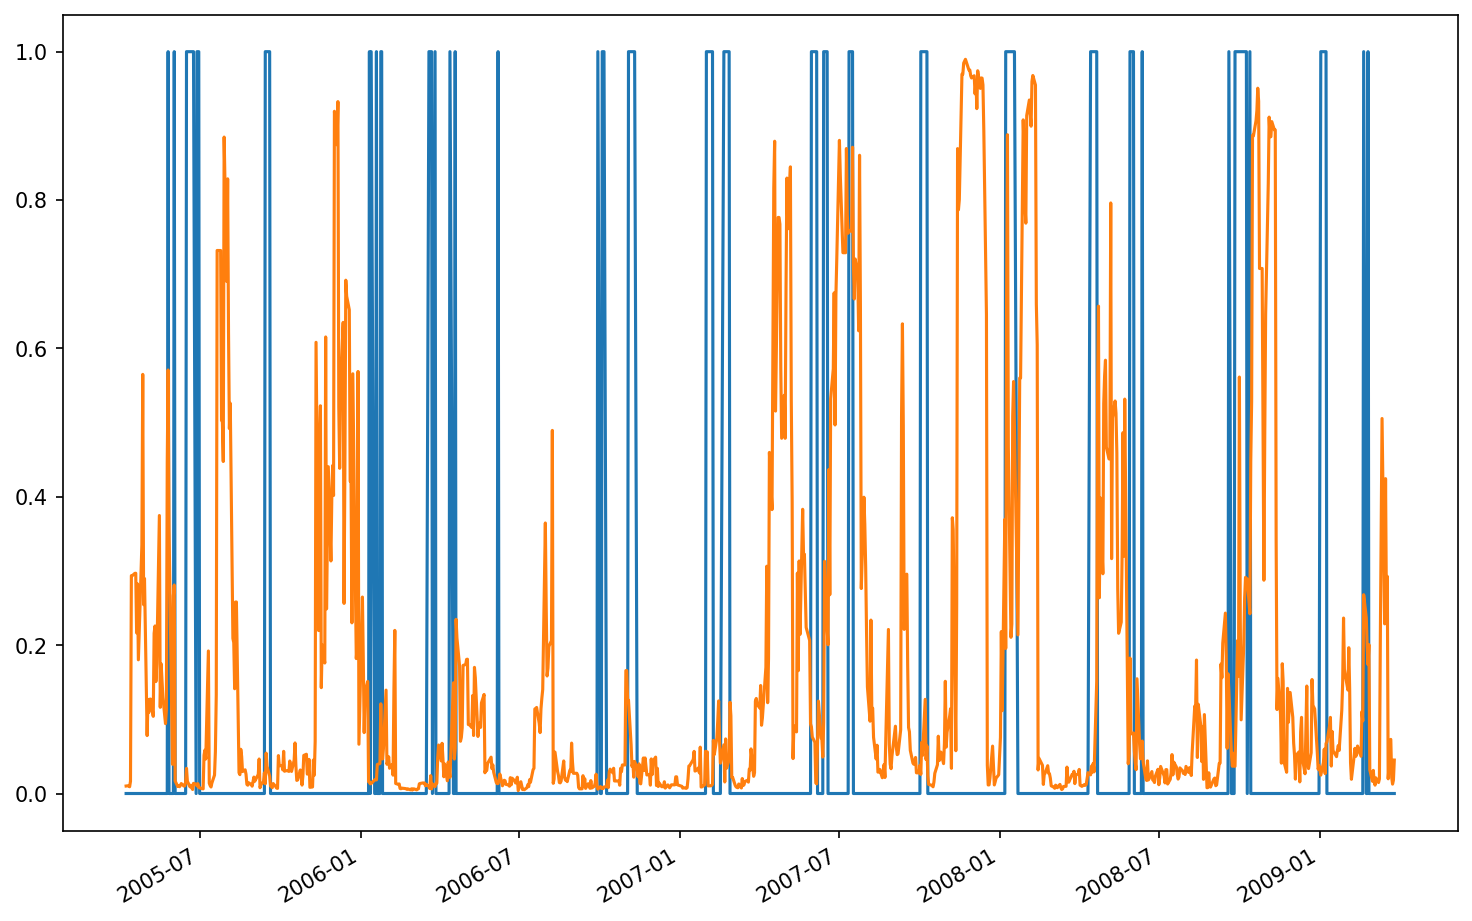

In [1204]:
df2.stop_loss_week_flag[1000:2000].astype(int).plot()
pd.Series(index=df2.stop_loss_month_flag[1000:2000].index, data=preds).plot()

In [1205]:
confusion_matrix(df2.stop_loss_month_flag[1000:2000], preds > 0.5)

array([[532,  98],
       [331,  39]], dtype=int64)

In [4]:
# TODO
# kfolds
# parameters
# balance classification data: true positives == true negatives
# normalise features (and simplify)
# measure how good probabilities are? of course preds > 0.5 is going to be incorrect. We want probability
# from above would an alternative model be better, like more basic linear regression?

# Portfolio optimisation

In [290]:
C=10; Qo=100; Qn=10; Wpct=0.01; SL=9.0; Pl=0.35; fexit=0.0045; fentry=0.0045

win = (Qo+Qn)*C*Wpct 
loss = (Qo+Qn)*(Pl*(C-SL)+SL*fexit)
# loss=win*1.05
value = win - loss + C*min(Qn, 0)*fexit - C*max(Qn, 0)*fentry + C*(Qo+min(Qn, 0))*fentry
try:
    kelly = value / win
except:
    kelly = 0.0
print(f"win: {win:.2f}\tloss: {loss:.2f}\tvalue: {value:.2f}\tkelly: {kelly:.2f}")

win: 11.00	loss: 42.95	value: -27.91	kelly: -2.54


In [291]:
(win-loss)/win

-2.905